In [1]:
# default_exp standard_themes/saw

In [2]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Tritonlytics Multilabel Classification - Standard S@W Themes

> Models to predict what standard themes a verbatim belongs too

In [3]:
#export
import datetime
import sklearn.metrics as skm
from tritonlytics_ai.utils import *

from fastai import __version__ as fa2_version
from fastai.text.all import *

import spacy
spacy_en = spacy.load('en_core_web_sm')
spacy_es = spacy.load('es_core_news_sm')

In [4]:
#hide
import pdb, gc

# pandas and plotting config
import seaborn as sns
sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (9,6)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

from nbdev.showdoc import *
from fastcore.test import *

In [5]:
#hide
print(f'fastai version: {fa2_version}')

fastai version: 2.0.14


In [6]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}')

Using GPU #1


## Data

Basic Configuration

In [7]:
vocab = pickle.load(open(LM_PATH/'vocab.pkl', 'rb')); len(vocab)

32408

In [8]:
bsz = 80
bptt= 72
wd = 1e-7

In [9]:
chunksize = 24000

include_fld_tok = False
include_bos_tok = True
include_eos_tok = False

In [10]:
# define what text columns to use (can be multiple)
corpus_cols = ['answer_text'] 

# define how to identify the text we are using for the LM
corpus_suf = '' #'_cleaned'

Prepare the data source

In [11]:
train_df = pd.read_csv(STANDARD_THEME_SAW_PATH/'train.csv')
valid_df = pd.read_csv(STANDARD_THEME_SAW_PATH/'test.csv')

In [12]:
train_df.survey_id.value_counts()

212    1635
160     909
396     304
398     284
401      12
Name: survey_id, dtype: int64

Remove any rows whre the "corpus_cols" are nan

In [13]:
train_df.dropna(subset=corpus_cols, inplace=True)
valid_df.dropna(subset=corpus_cols, inplace=True)

In [14]:
STANDARD_THEME_SAW_LABELS

['adequate_staffing',
 'advancement_and_training_opportunities',
 'appropriate_stress_work_assigned_equitably',
 'benefits',
 'better_ways_recognized_participate_in_decisions',
 'career_advancement',
 'committed_to_diversity',
 'communicates_essential_information',
 'ethical_conduct_perform_responsibilities_spirit_of_cooperation',
 'evaluated_fairly',
 'experienced_discrimination',
 'facilities_workspace_safety',
 'faculty_value_contributions',
 'favoritism_cliques',
 'fear_of_retaliation_negative_consequences',
 'feel_valued_by_department',
 'flexibility_work_life_balance',
 'good_use_of_skills',
 'have_necessary_tools',
 'have_voice_within_my_institution_valued_member_of_my_institution',
 'internal_processes_effective',
 'parking_transportation',
 'salary_pay',
 'satisfied_with_diversity_progams',
 'supervisor_effectiveness_resolves_staff_issues']

In [15]:
# 11/15/2018 - currently have to put all labels into a single column
# train_df['labels'] = train_df[SENT_LABELS[1:]].apply(lambda row: ' '.join(row.columns[row.values == 1]), axis=1)
# valid_df['labels'] = valid_df[SENT_LABELS[1:]].apply(lambda row: ' '.join(row.columns[row.values == 1], axis=1)

train_df['labels'] = train_df[STANDARD_THEME_SAW_LABELS].apply(
    lambda x: ' '.join(x.index[x.astype(bool)]), axis=1)
valid_df['labels'] = valid_df[STANDARD_THEME_SAW_LABELS].apply(
    lambda x: ' '.join(x.index[x.astype(bool)]), axis=1)

train_df[['labels'] + STANDARD_THEME_SAW_LABELS].head()

,labels,adequate_staffing,advancement_and_training_opportunities,appropriate_stress_work_assigned_equitably,benefits,better_ways_recognized_participate_in_decisions,career_advancement,committed_to_diversity,communicates_essential_information,ethical_conduct_perform_responsibilities_spirit_of_cooperation,evaluated_fairly,experienced_discrimination,facilities_workspace_safety,faculty_value_contributions,favoritism_cliques,fear_of_retaliation_negative_consequences,feel_valued_by_department,flexibility_work_life_balance,good_use_of_skills,have_necessary_tools,have_voice_within_my_institution_valued_member_of_my_institution,internal_processes_effective,parking_transportation,salary_pay,satisfied_with_diversity_progams,supervisor_effectiveness_resolves_staff_issues
0,committed_to_diversity feel_valued_by_department satisfied_with_diversity_progams,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,have_voice_within_my_institution_valued_member_of_my_institution,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,ethical_conduct_perform_responsibilities_spirit_of_cooperation experienced_discrimination,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,adequate_staffing salary_pay,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,appropriate_stress_work_assigned_equitably faculty_value_contributions,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
train_df['is_valid'] = False
valid_df['is_valid'] = True
df = pd.concat([train_df, valid_df])

In [17]:
# prepend custom tokenization rules to defaults
custom_lowercase = partial(lowercase, add_bos=include_bos_tok, add_eos=include_eos_tok)

custom_tok_rules = defaults.text_proc_rules[:-1] + [custom_lowercase, 
                                                    make_replacements, 
                                                    fix_ampm, 
                                                    fix_sentence_ends, 
                                                    fix_hyphenated_words]

Using the low-level `Datasets` API

In [18]:
%%time

x_tfms = [
    attrgetter('text'), 
    Tokenizer.from_df(text_cols=corpus_cols, rules=custom_tok_rules, mark_fields=include_fld_tok), 
    Numericalize(vocab=vocab)
]

y_tfms = [ 
    ColReader(STANDARD_THEME_SAW_LABELS),
    EncodedMultiCategorize(vocab=STANDARD_THEME_SAW_LABELS),
]

dsets = Datasets(items=df,
                 tfms=[x_tfms, y_tfms], 
                 splits=ColSplitter(col='is_valid')(df), 
                 dl_type=SortedDL)

len(dsets.train), len(dsets.valid)

CPU times: user 365 ms, sys: 218 ms, total: 583 ms
Wall time: 908 ms


(3144, 350)

In [19]:
%%time
dls = dsets.dataloaders(bs=bsz, seq_len=bptt, before_batch=pad_input_chunk)

CPU times: user 4.91 s, sys: 1.04 s, total: 5.94 s
Wall time: 5.97 s


In [20]:
print((
    f'The Datasets vocab has {len(dls.vocab)} items : the inputs vocab ({len(dls.vocab[0])} items), '
    f'and the targets ({len(dls.vocab[1])} items)'))

The Datasets vocab has 2 items : the inputs vocab (32408 items), and the targets (25 items)


In [21]:
print(dls.train_ds[21])

(TensorText([    2,     8,    44,    15,   348,  1294,   309,    68,  8544,   339,
         3614,    10,  1595,  4626,    11,    79,   339,    12,   352,    51,
           18,    74,    95,    16,    10,  2230,   180,    29,  1674,    68,
        21272,    68,  6488,    33,     9,     8,    49,    23,    15,    70,
          154,  2091,    29,   113,  3140,    18,    12,    80,    17,    74,
           95,    12,  1567,    58,    70,   339,   356,    28,   359,    58,
           11,    62,  1088,     9,     8,   327,    13,   266,    15,   736,
           11,    22,   588,    16,  1927,    13,   615,    13,    12,  2360,
           78,  1044,   664,    51,    19,    59,     9,     8,  1567,  1941,
           84,    10,  1934,  2674,    10,   195,    17,   266,    62,  1088,
           12,   266,  5469,    17,   710,     9,     8,    28,   235,    58,
          725,   398,    11,   117,    69,  1088,    12,    14,    36,    39,
           23,    10,  1742,    14,    73,    47,    28,   

In [22]:
dls.show_batch(max_n=2)

,text,None
0,"xxbos xxmaj in the xxmaj enterprise xxmaj network and xxmaj telecommunications group of xxup its , the environment continues to be toxic , retaliatory , abusive , and discriminatory as in past years . xxmaj under the direction of xxmaj james xxmaj seddon , supervisor xxmaj malerie xxmaj samadi harasses and talks down to employees . xxmaj manipulates and edits official documentation to make staff look and give lower performance appraisal ratings or retaliate against them . xxmaj also , use the same practice to provide their friends with higher performance ratings and award them with higher merit increases . xxmaj senior management continues to harbor this behavior without any consequence and or accountability . xxmaj james and xxmaj malerie exploit minorities and give preferential treatment to personnel hired by them . xxmaj regularly abuse the power that the xxmaj university of xxmaj california gives them and exercise nepotism because",ethical_conduct_perform_responsibilities_spirit_of_cooperation;evaluated_fairly;favoritism_cliques;fear_of_retaliation_negative_consequences;supervisor_effectiveness_resolves_staff_issues
1,"xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxbos xxmaj insights as alumna / former student of xxup ucsd , working on main campus 3.5 + years , mexican - american female & varied experience from start - up to non - profit to corporate : \ r \n 1 . xxmaj dept / culture : all , not just leadership / xxup hr- trained yearly on effective leadership , diversity / inclusivity , utilizing technology & innovative ideas on team dynamics / future of work",advancement_and_training_opportunities;committed_to_diversity;flexibility_work_life_balance;parking_transportation;salary_pay


In [23]:
batch = next(iter(dls.train))
print(batch[0].size(), batch[0].type(), batch[1].size(), batch[1].type(), bsz)

torch.Size([80, 467]) torch.cuda.LongTensor torch.Size([80, 25]) torch.cuda.FloatTensor 80


In [24]:
' '.join([ dls.vocab[0][idx] for idx in batch[0][0,:] ])

"xxbos xxmaj in the xxmaj enterprise xxmaj network and xxmaj telecommunications group of xxup its , the environment continues to be toxic , retaliatory , abusive , and discriminatory as in past years . xxmaj under the direction of xxmaj james xxmaj seddon , supervisor xxmaj malerie xxmaj samadi harasses and talks down to employees . xxmaj manipulates and edits official documentation to make staff look and give lower performance appraisal ratings or retaliate against them . xxmaj also , use the same practice to provide their friends with higher performance ratings and award them with higher merit increases . xxmaj senior management continues to harbor this behavior without any consequence and or accountability . xxmaj james and xxmaj malerie exploit minorities and give preferential treatment to personnel hired by them . xxmaj regularly abuse the power that the xxmaj university of xxmaj california gives them and exercise nepotism because they are both product of such practices . \\ r \n 

Using the mid-level `DataBlocks` API

In [25]:
%%time

blocks = (
    TextBlock.from_df(corpus_cols, vocab=vocab, seq_len=bptt, rules=custom_tok_rules, mark_fields=include_fld_tok),
    MultiCategoryBlock(encoded=True, vocab=STANDARD_THEME_SAW_LABELS)
)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('text'),
                   get_y=ColReader(STANDARD_THEME_SAW_LABELS),
                   splitter=ColSplitter(col='is_valid'))

CPU times: user 125 ms, sys: 6.96 ms, total: 132 ms
Wall time: 131 ms


In [26]:
# dblock.summary(df)

In [27]:
%%time
dls = dblock.dataloaders(df, bs=bsz, seq_len=bptt)

CPU times: user 4.21 s, sys: 739 ms, total: 4.95 s
Wall time: 5.27 s


In [28]:
print((
    f'The Datasets vocab has {len(dls.vocab)} items : the inputs vocab ({len(dls.vocab[0])} items), '
    f'and the targets ({len(dls.vocab[1])} items)'))

The Datasets vocab has 2 items : the inputs vocab (32408 items), and the targets (25 items)


In [29]:
print(dls.train_ds[21])

(TensorText([    2,     8,    44,    15,   348,  1294,   309,    68,  8544,   339,
         3614,    10,  1595,  4626,    11,    79,   339,    12,   352,    51,
           18,    74,    95,    16,    10,  2230,   180,    29,  1674,    68,
        21272,    68,  6488,    33,     9,     8,    49,    23,    15,    70,
          154,  2091,    29,   113,  3140,    18,    12,    80,    17,    74,
           95,    12,  1567,    58,    70,   339,   356,    28,   359,    58,
           11,    62,  1088,     9,     8,   327,    13,   266,    15,   736,
           11,    22,   588,    16,  1927,    13,   615,    13,    12,  2360,
           78,  1044,   664,    51,    19,    59,     9,     8,  1567,  1941,
           84,    10,  1934,  2674,    10,   195,    17,   266,    62,  1088,
           12,   266,  5469,    17,   710,     9,     8,    28,   235,    58,
          725,   398,    11,   117,    69,  1088,    12,    14,    36,    39,
           23,    10,  1742,    14,    73,    47,    28,   

In [30]:
dls.show_batch(max_n=2)

,text,None
0,"xxbos xxmaj in the xxmaj enterprise xxmaj network and xxmaj telecommunications group of xxup its , the environment continues to be toxic , retaliatory , abusive , and discriminatory as in past years . xxmaj under the direction of xxmaj james xxmaj seddon , supervisor xxmaj malerie xxmaj samadi harasses and talks down to employees . xxmaj manipulates and edits official documentation to make staff look and give lower performance appraisal ratings or retaliate against them . xxmaj also , use the same practice to provide their friends with higher performance ratings and award them with higher merit increases . xxmaj senior management continues to harbor this behavior without any consequence and or accountability . xxmaj james and xxmaj malerie exploit minorities and give preferential treatment to personnel hired by them . xxmaj regularly abuse the power that the xxmaj university of xxmaj california gives them and exercise nepotism because",ethical_conduct_perform_responsibilities_spirit_of_cooperation;evaluated_fairly;favoritism_cliques;fear_of_retaliation_negative_consequences;supervisor_effectiveness_resolves_staff_issues
1,"xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxbos xxmaj insights as alumna / former student of xxup ucsd , working on main campus 3.5 + years , mexican - american female & varied experience from start - up to non - profit to corporate : \ r \n 1 . xxmaj dept / culture : all , not just leadership / xxup hr- trained yearly on effective leadership , diversity / inclusivity , utilizing technology & innovative ideas on team dynamics / future of work",advancement_and_training_opportunities;committed_to_diversity;flexibility_work_life_balance;parking_transportation;salary_pay


In [31]:
batch = next(iter(dls.train))
print(batch[0].size(), batch[0].type(), batch[1].size(), batch[1].type(), bsz)

torch.Size([80, 467]) torch.cuda.LongTensor torch.Size([80, 25]) torch.cuda.FloatTensor 80


In [32]:
' '.join([ dls.vocab[0][idx] for idx in batch[0][0,:] ])

"xxbos xxmaj in the xxmaj enterprise xxmaj network and xxmaj telecommunications group of xxup its , the environment continues to be toxic , retaliatory , abusive , and discriminatory as in past years . xxmaj under the direction of xxmaj james xxmaj seddon , supervisor xxmaj malerie xxmaj samadi harasses and talks down to employees . xxmaj manipulates and edits official documentation to make staff look and give lower performance appraisal ratings or retaliate against them . xxmaj also , use the same practice to provide their friends with higher performance ratings and award them with higher merit increases . xxmaj senior management continues to harbor this behavior without any consequence and or accountability . xxmaj james and xxmaj malerie exploit minorities and give preferential treatment to personnel hired by them . xxmaj regularly abuse the power that the xxmaj university of xxmaj california gives them and exercise nepotism because they are both product of such practices . \\ r \n 

Save the `Dataloaders` object for future use

In [33]:
# save dataloaders
torch.save(dls, STANDARD_THEME_SAW_PATH/f'data_cls_standard_themes_saw.pkl')
# dls = torch.load(STANDARD_THEME_SAW_PATH/f'data_cls_standard_themes_saw.pkl')

## Training

Configure a forward or backwards run

In [34]:
backwards = False
m_suf = '_multilabel' #'_cleaned'
m_pre = 'bwd_' if (backwards) else 'fwd_'

dls = torch.load(STANDARD_THEME_SAW_PATH/f'data_cls_standard_themes_saw.pkl')

def reverse_text(nums): return nums.flip(0)
if (backwards): 
    dls.tfms.append(Transform(reverse_text))
    dls.before_batch = partial(pad_input_chunk, pad_first=not backwards)

In [35]:
# copied from /lm/models -> class/models (both fwd and bwd weights)
! cp {LM_PATH/'models/*_lm_enc.pth'} {STANDARD_THEME_SAW_PATH/'models/'}  

Configure our metrics

In [36]:
# define metrics
beta, start, end, average, sample_weight = 1, 0.08, 0.7, 'weighted', None

# custom
opt_th_metrics = OptimalMultiThresholdMetrics(beta=beta, start=start, end=end, 
                                              average=average, sample_weight=sample_weight)

opt_th_metric = opt_th_metrics.best_thresh()
opt_fscore_metric = opt_th_metrics.best_fscore()
opt_acc_metric = opt_th_metrics.best_faccuracy()

# standard
fbeta1_metric = FBetaMulti(beta=beta, average=average, sample_weight=sample_weight)
prec_metric = PrecisionMulti(average=average, sample_weight=sample_weight)
recall_metric = RecallMulti(average=average, sample_weight=sample_weight)
roc_auc_metric = RocAucMulti(average=average, sample_weight=sample_weight)

Configure our loss

In [37]:
label_counts = { col: train_df[col].value_counts().to_dict() for col in dls.tfms[1].vocab }
most_common_label = max(label_counts.keys(), key=(lambda k: label_counts[k][1]))

for lbl in label_counts: label_counts[lbl]['weight'] = label_counts[most_common_label][1] / label_counts[lbl][1]
    
pos_weight_vec = [v['weight'] * 1. if v['weight'] != 1.0 else v['weight'] for k,v in label_counts.items()]
pos_weight_vec

[1.7191780821917808,
 2.9186046511627906,
 1.818840579710145,
 6.197530864197531,
 2.901734104046243,
 2.1545064377682404,
 2.42512077294686,
 3.5104895104895104,
 1.0,
 4.87378640776699,
 1.953307392996109,
 3.585714285714286,
 1.3715846994535519,
 5.516483516483516,
 1.2838874680306904,
 1.480825958702065,
 4.442477876106195,
 7.492537313432836,
 11.409090909090908,
 2.3904761904761904,
 2.6145833333333335,
 5.7701149425287355,
 1.1409090909090909,
 1.9609375,
 1.1409090909090909]

In [38]:
loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=tensor(pos_weight_vec).to('cuda:1'))
loss_func.thresh = 0.5
# loss_func = BCEWithLogitsLossFlat(pos_weight=tensor(pos_weight_vec*bsz, device=torch.cuda.current_device()))

Configure learner

In [39]:
# define callbacks
best_model_cb = SaveModelCallback(monitor='fbeta_score', comp=np.greater, fname=f'{m_pre}cls_bestmodel{m_suf}')

opt_thresh_cb = OptimizeFBetaThreshCallback(beta=beta, average=average, sample_weight=sample_weight,
                                            start=start, end=end)

In [68]:
learn_cbs = []
fit_cbs = [best_model_cb, opt_thresh_cb]

learn_metrics = [ 
    accuracy_multi, fbeta1_metric, prec_metric, recall_metric, roc_auc_metric,
    # opt_th_metric, opt_fscore_metric, opt_acc_metric # => only include for testing
]

# build learner
learn = text_classifier_learner(dls, 
                                AWD_LSTM, 
                                pretrained=False,
                                alpha=2.0, beta=1.0,      # default - alpha=2.0, beta=1.0
                                moms=(0.95, 0.85, 0.95),  # default - (0.95, 0.85, 0.95)
                                wd=wd,                    # default - None
                                seq_len=bptt,             # default - 72
                                drop_mult=0.5,            # default - 0.5
                                lin_ftrs=[50],            # default - [50]
                                ps=[0.1],                 # default - [0.1]
                                metrics=learn_metrics, 
                                loss_func=loss_func,
                                cbs=learn_cbs,
                                path=STANDARD_THEME_SAW_PATH)

learn.opt = learn.create_opt()

In [69]:
# learn.summary()

In [70]:
# learn.show_training_loop()

In [71]:
learn = learn.load_encoder(f'{m_pre}lm_enc')

In [72]:
best_model_path = STANDARD_THEME_SAW_PATH/f'models/{m_pre}cls_bestmodel{m_suf}*'
if (best_model_path.exists()): best_model_path.unlink(missing_ok=False)

Train

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.0691830962896347)

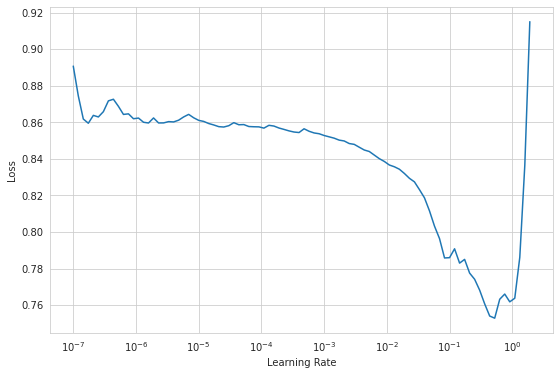

In [73]:
learn.lr_find()

In [74]:
lr= 1e-1

In [75]:
learn.fit_one_cycle(1, lr_max=lr, cbs=fit_cbs)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,time
0,0.525723,0.398374,0.727771,0.269017,0.233357,0.552860,0.650565,00:06


Better model found at epoch 0 with fbeta_score value: 0.2690167800750152.


In [76]:
learn.save(f'{m_pre}cls_last_ft{m_suf}')

Path('data/classification/standard_themes/saw/models/fwd_cls_last_ft_multilabel.pth')

In [77]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, lr_max=slice(5e-2/(2.6**4), 5e-2), cbs=fit_cbs)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,time
0,0.391824,0.354774,0.500800,0.223245,0.129565,0.909879,0.672638,00:07


Better model found at epoch 0 with fbeta_score value: 0.2232450024830479.


In [78]:
learn.save(f'{m_pre}cls_last2_ft{m_suf}')

Path('data/classification/standard_themes/saw/models/fwd_cls_last2_ft_multilabel.pth')

In [79]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, lr_max=slice(1e-2/(2.6**4),5e-3), cbs=fit_cbs)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,time
0,0.331870,0.338222,0.534971,0.227685,0.131349,0.920277,0.684655,00:08


Better model found at epoch 0 with fbeta_score value: 0.22768509670429063.


In [80]:
learn.save(f'{m_pre}cls_last3_ft{m_suf}')

Path('data/classification/standard_themes/saw/models/fwd_cls_last3_ft_multilabel.pth')

In [81]:
learn.unfreeze()
learn.fit_one_cycle(20, lr_max=slice(5e-3/(2.6**4),5e-3), cbs=fit_cbs)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,time
0,0.314037,0.337044,0.553029,0.229916,0.133108,0.902946,0.685128,00:10
1,0.312598,0.348382,0.624914,0.251725,0.148903,0.868284,0.708358,00:10
2,0.303538,0.333393,0.633371,0.258925,0.153292,0.883882,0.719007,00:10
3,0.292031,0.335112,0.707657,0.289432,0.176873,0.838821,0.739217,00:10
4,0.279064,0.351046,0.718743,0.299092,0.183772,0.849220,0.746018,00:10
5,0.258180,0.362531,0.745143,0.303383,0.188969,0.797227,0.741491,00:10
6,0.240436,0.430774,0.729600,0.300641,0.186565,0.826690,0.735796,00:10
7,0.218958,0.383278,0.752343,0.307943,0.193403,0.793761,0.738468,00:10
8,0.200907,0.384290,0.766171,0.313261,0.198715,0.774697,0.735779,00:10
9,0.185686,0.403602,0.813257,0.339719,0.226243,0.708839,0.734743,00:10


Better model found at epoch 0 with fbeta_score value: 0.22991563386126596.
Better model found at epoch 1 with fbeta_score value: 0.25172535185515765.
Better model found at epoch 2 with fbeta_score value: 0.2589252065460322.
Better model found at epoch 3 with fbeta_score value: 0.2894322155948234.
Better model found at epoch 4 with fbeta_score value: 0.2990921816951586.
Better model found at epoch 5 with fbeta_score value: 0.3033825451705406.
Better model found at epoch 7 with fbeta_score value: 0.30794310237789185.
Better model found at epoch 8 with fbeta_score value: 0.313261407436941.
Better model found at epoch 9 with fbeta_score value: 0.3397191164681151.
Better model found at epoch 10 with fbeta_score value: 0.34121102037913126.
Better model found at epoch 11 with fbeta_score value: 0.3774343263929475.
Better model found at epoch 14 with fbeta_score value: 0.3779964697194522.
Better model found at epoch 15 with fbeta_score value: 0.39899560156550384.


In [82]:
learn.loss_func.thresh # => not part of pytorch BCE loss function (so added above)

0.09

In [83]:
learn.save(f'{m_pre}cls{m_suf}')

Path('data/classification/standard_themes/saw/models/fwd_cls_multilabel.pth')

Export model for inference

In [84]:
learn.export(fname=f'{m_pre}export_clas{m_suf}.pkl')

Look at results

In [85]:
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')

In [86]:
learn.validate() # ... returns [loss, metrics]

(#6) [0.4549393653869629,0.842628538608551,0.36456865507258296,0.2544445038542579,0.6707105719237435,0.7377861407651665]

In [87]:
# learn.show_results(max_n=4, trunc_at=60) #=> throws an exception right now!!!

In [88]:
interp = Interpretation.from_learner(learn)

In [89]:
interp.plot_top_losses(k=5)

,input,target,predicted,probability,loss
0,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxbos i feel that there are,advancement_and_training_opportunities;benefits;career_advancement;evaluated_fairly;favoritism_cliques;salary_pay,,0.8231351375579834,5.981392860412598
1,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxbos i believe my department does,adequate_staffing;feel_valued_by_department;have_necessary_tools;have_voice_within_my_institution_valued_member_of_my_institution,,-0.23083782196044922,5.30182409286499
2,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,facilities_workspace_safety;flexibility_work_life_balance,,29.304550170898438,3.8996965885162354
3,xxbos i think vehicles are a huge issue how can one have the tools needed to complete there work when there is not a main tool to get you to the job . i understand carbon foot print but lets get electric vehicles or natural gas vehicles . we should not have to share everything to get a job done efficiently . \ r \n i still feel discriminated against because i do n't speak xxmaj spanish . it is rude of coworkers to speak another language another coworker does n't understand . we are an xxmaj english speaking country and work place . it is a prerequisite to get hired here to speak and read xxmaj english but as soon as they are hired they speak another language and it is really bad communication and extremely rude . \ r \n my voice will never be heard at campus,experienced_discrimination;have_necessary_tools,,1.4015518426895142,3.582

Use it for inference

In [90]:
inf_learn = load_learner(STANDARD_THEME_SAW_PATH/f'{m_pre}export_clas{m_suf}.pkl')

In [91]:
inf_learn.loss_func.thresh

0.09

In [92]:
inf_learn.predict('I feel very uncomfortable talking to my supervisor even though she loves dogs. Help!!!', 
                  with_input=True)

('xxbos i feel very uncomfortable talking to my supervisor even though she loves dogs . xxmaj help xxrep 3 !',
 (#0) [],
 tensor([ -3.7491, -13.1441,  -5.1881, -12.2135,  -8.2177,  -9.2570,  -7.8509,
          -9.7869,  -0.7237,  -9.7433,  -3.2595,  -8.7444,  -2.1651,  -9.7573,
          -2.1117,  -0.3140,  -7.8909, -12.4261, -13.5897,  -4.5630, -14.2065,
         -11.7939,  -6.8554,  -3.5361,  -2.1159]),
 tensor([ -3.7491, -13.1441,  -5.1881, -12.2135,  -8.2177,  -9.2570,  -7.8509,
          -9.7869,  -0.7237,  -9.7433,  -3.2595,  -8.7444,  -2.1651,  -9.7573,
          -2.1117,  -0.3140,  -7.8909, -12.4261, -13.5897,  -4.5630, -14.2065,
         -11.7939,  -6.8554,  -3.5361,  -2.1159]))

Review final validation loss for best model

In [93]:
print(STANDARD_THEME_SAW_LABELS)

['adequate_staffing', 'advancement_and_training_opportunities', 'appropriate_stress_work_assigned_equitably', 'benefits', 'better_ways_recognized_participate_in_decisions', 'career_advancement', 'committed_to_diversity', 'communicates_essential_information', 'ethical_conduct_perform_responsibilities_spirit_of_cooperation', 'evaluated_fairly', 'experienced_discrimination', 'facilities_workspace_safety', 'faculty_value_contributions', 'favoritism_cliques', 'fear_of_retaliation_negative_consequences', 'feel_valued_by_department', 'flexibility_work_life_balance', 'good_use_of_skills', 'have_necessary_tools', 'have_voice_within_my_institution_valued_member_of_my_institution', 'internal_processes_effective', 'parking_transportation', 'salary_pay', 'satisfied_with_diversity_progams', 'supervisor_effectiveness_resolves_staff_issues']


In [94]:
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')

In [95]:
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')
probs, targs, loss = learn.get_preds(dl=dls.valid, with_loss=True)

print(f'Validation Loss: {loss.mean()}')
# print(f'Validation Loss (per label): {loss.mean(dim=0)}') # ... no longer works (see forum comment from sylvain)

Validation Loss: 0.4549393653869629


In [96]:
learn.predict("The faculty really support us well!!!  It's great working and I feel valued")

((#0) [],
 tensor([ -4.8405,  -7.2025,  -3.5792, -15.2430,   0.9983,  -6.3963, -10.9790,
         -10.7048,  -2.8645,  -7.9670,  -4.9883, -10.5666,   1.5062, -14.7631,
          -8.1865,   1.6558,  -9.1927,  -7.6678, -10.0515,  -2.7138,  -7.8088,
         -13.1808,  -5.8227,  -5.4734,  -4.0097]),
 tensor([ -4.8405,  -7.2025,  -3.5792, -15.2430,   0.9983,  -6.3963, -10.9790,
         -10.7048,  -2.8645,  -7.9670,  -4.9883, -10.5666,   1.5062, -14.7631,
          -8.1865,   1.6558,  -9.1927,  -7.6678, -10.0515,  -2.7138,  -7.8088,
         -13.1808,  -5.8227,  -5.4734,  -4.0097]))

## Review

### Lets look at validation metrics

In [97]:
# predictions for a single model using the learner's model and data loaders
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')
learn.model.cuda(1)
raw_inputs, probs, targs  = learn.get_preds(with_input=True)

len(raw_inputs), probs.shape, targs.shape, len(dls.valid_ds), dls.c, learn.loss_func.thresh

(350, torch.Size([350, 25]), torch.Size([350, 25]), 350, 25, 0.09)

In [98]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)

In [99]:
threshold_f05 = f05.opt_th(probs, targs)
threshold_f1 = f1.opt_th(probs, targs)
threshold_f2 = f2.opt_th(probs, targs)

threshold_f05, threshold_f1, threshold_f2

(0.4700000000000001, 0.060000000000000005, 0.060000000000000005)

In [100]:
f05_score = f05.opt_fscore(probs, targs)
f1_score = f1.opt_fscore(probs, targs)
f2_score = f2.opt_fscore(probs, targs)

f05_score, f1_score, f2_score

(0.3682293801684971, 0.31270209130722937, 0.28327856151787467)

In [101]:
# make sure we are getting the same f1 score as sklearn
res = skm.fbeta_score(targs, (probs > threshold_f1), beta=1, 
                      average=average, sample_weight=sample_weight, zero_division=False)
res

0.31270209130722937

In [102]:
# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs, targs, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs, targs, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs, targs, threshold_f2, sigmoid=False).item()

val_acc_f05, val_acc_f1, val_acc_f2

(0.9319999814033508, 0.9267428517341614, 0.9267428517341614)

In [103]:
# make sure we are getting the same f1 accuracy
preds = ((probs > threshold_f1).byte() == targs.byte()).float().mean()
preds.item()

0.9267428517341614

### Overall metrics

In [104]:
eval_targs = targs.flatten() # targs[:,0]
eval_probs = probs.flatten() # probs[:,0]

#### Classification Accuracy

The percentage of correct predictions.  Answers the question, *"Overall, how often is the classifier correct?"*

In [105]:
# In multilabel classification, this function computes subset accuracy: 
# the set of labels predicted for a sample must exactly match ALL the corresponding set of labels in y_true.
print(skm.accuracy_score(targs, (probs > threshold_f1), sample_weight=sample_weight))

0.18285714285714286


In [106]:
print(skm.accuracy_score(eval_targs, (eval_probs > threshold_f1).float(), sample_weight=sample_weight))

0.9267428571428571


#### Null Accuracy
 
The accuracy achieved by always predicting the most frequent class.  Answers the question, *"What would the accuracy be by always predicting the most frequent case?"*

In [107]:
u_classes, u_counts = np.unique(eval_targs, return_counts=True)
most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
print(most_freq_class, most_freq_class_count)

0.0 8173


In [108]:
most_freq_class_count / len(eval_targs)

0.9340571428571428

#### Cohen's kappa

This measure is intended to compare labelings by different human annotators (not a classifier vs. ground truth)

Kappa socres are between -1 and 1 ( >= .8 is generally considered good agreement; <= 0 means no agreement ... e.g., practically random labels)

In [109]:
print(skm.cohen_kappa_score(eval_targs, (eval_probs > threshold_f1).float(), 
                            weights=None, sample_weight=sample_weight))

0.2891006373663534


#### Confusion Matrix

Describes the performance of a classification model

In [110]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues, print_info=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if (print_info): print("Normalized confusion matrix")
    else:
        if (print_info): print('Confusion matrix, without normalization')

    if (print_info): print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)

In [111]:
cm = skm.confusion_matrix(eval_targs, (eval_probs > threshold_f1).float(), sample_weight=sample_weight)

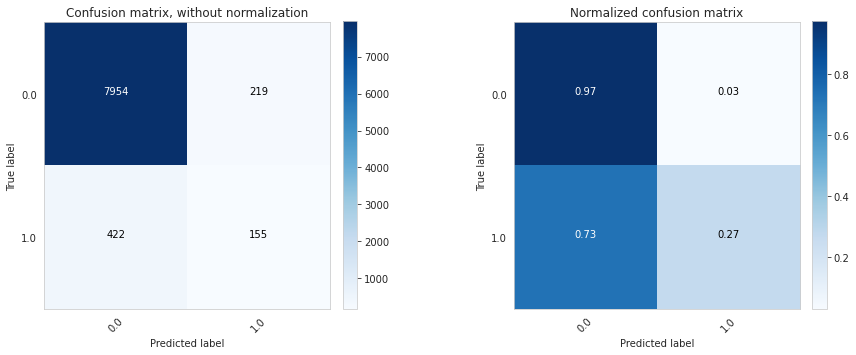

In [112]:
# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cm, classes=u_classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cm, classes=u_classes, normalize=True,
                      title='Normalized confusion matrix')

fig.subplots_adjust(wspace=0.5)
plt.show()

In [113]:
print(skm.classification_report(eval_targs, (eval_probs > threshold_f1).float(), [0,1], 
                                sample_weight=sample_weight))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      8173
           1       0.41      0.27      0.33       577

    accuracy                           0.93      8750
   macro avg       0.68      0.62      0.64      8750
weighted avg       0.91      0.93      0.92      8750



/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


#### Raw probability distribution

Useful to see how the threshold can be adjusted to increase sensitivity or specificity

Text(0, 0.5, 'Frequency')

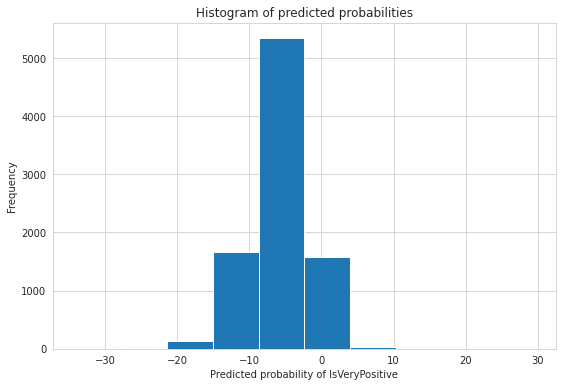

In [114]:
plt.hist(eval_probs, bins=10)
# plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of IsVeryPositive')
plt.ylabel('Frequency')

#### ROC curves and Area Under the Curve (AUC)

***ROC Curve*** answers the question, *"How would sensitivity and specificity be affected by various thresholds without changing the threshold?"*  It is a way **to visualize the performance of a binary classifier.**

The ROC curve can help you **choose a threshold** that balances sensitivity and specificity based on your particular business case.

ROC curves visualize all possible classification thresholds whereas misclassification rate only represents your error rate for a single threshold.

A classifier that does a good job at separating the classes will have a ROC curve that hugs the upper left corner of the plot.  Converseley, a classifier the does a poor job separating the classes will have a ROC curve that is close to the diagonal line (0,0 -> 1,1).  That diagonal line represents a classifier that does no better than random guessing.

In [115]:
fpr, tpr, thresholds = skm.roc_curve(eval_targs, eval_probs, sample_weight=sample_weight)

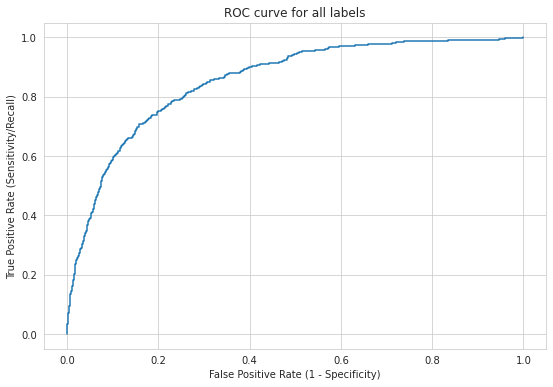

In [116]:
plt.plot(fpr, tpr)
plt.xlim = ([0.0, 1.0])
plt.ylim = ([0.0, 1.0])
plt.title('ROC curve for all labels')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.grid(True)

***AUC*** = the percentage of the ROC plot that is underneath the curve.  

AUC summarizes the performance of a classifier in a **single number**.  It says, *"If you randomly chose one positive and one negative observation, what is the likelihood that your classifier will assign a higher predicted probability to the positive observation."*

**An AUC of ~ 0.8 is very good while an AUC of ~ 0.5 represents a poor classifier.**

The ROC curve and AUC are insensitive to whether your predicted probabilities are properly calibrated to actually represent probabilities of class membership (e.g., it works if predicted probs range from 0.9 to 1 instead of 0 to 1).  All the AUC metric cares about is how well your classifier separated the two classes

Notes:
1.  AUC is useful even when there is **high class imbalance** (unlike classification accuracy)
2.  AUC is useful even when predicted probabilities are not properly calibrated (e.g., not between 0 and 1)

In [117]:
print(skm.roc_auc_score(eval_targs, eval_probs, average=average, sample_weight=sample_weight))

0.8542414989881931


### Let's look at things by label by label

In [118]:
label_metrics = {
    'thresholds': { 'f-beta05': threshold_f05, 'f-beta1': threshold_f1, 'f-beta2': threshold_f2 }
}

for idx, lbl in enumerate(STANDARD_THEME_SAW_LABELS):
    lbl_name, lbl_idx, lbl_targs, lbl_probs = lbl, idx, targs[:,idx], probs[:, idx]
    
    label_metrics[lbl_name] = {}
    label_metrics[lbl_name]['accuracies'] = {}
    label_metrics[lbl_name]['cohen_kappas'] = {}
    label_metrics[lbl_name]['confusion_matrices'] = {}
    label_metrics[lbl_name]['roc'] = {}
    label_metrics[lbl_name]['report'] = {}
    
    # get null accuracy (accuracy we'd get if we simply predicted the most common class)
    u_classes, u_counts = np.unique(lbl_targs, return_counts=True)
    most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
    label_metrics[lbl_name]['null_accuracy'] = most_freq_class_count / len(lbl_targs)
    
    # get raw probability distribution
    label_metrics[lbl_name]['probability_distribution'] = np.histogram(lbl_probs)
    
    # roc/auc curve metrics
    label_metrics[lbl_name]['roc_auc'] = skm.roc_auc_score(lbl_targs, lbl_probs, 
                                                           average=average, sample_weight=sample_weight)
    
    fpr, tpr, thresholds = skm.roc_curve(lbl_targs, lbl_probs, sample_weight=sample_weight)
    label_metrics[lbl_name]['roc']['fpr'] = fpr
    label_metrics[lbl_name]['roc']['tpr'] = tpr
    label_metrics[lbl_name]['roc']['thresholds'] = thresholds
    
    for k,v in label_metrics['thresholds'].items():
        label_metrics[lbl_name]['accuracies'][k] = skm.accuracy_score(lbl_targs, (lbl_probs > v), 
                                                                      sample_weight=sample_weight)
        
        label_metrics[lbl_name]['cohen_kappas'][k] = skm.cohen_kappa_score(lbl_targs, (lbl_probs > v), 
                                                                           sample_weight=sample_weight)
        
        label_metrics[lbl_name]['confusion_matrices'][k] = skm.confusion_matrix(lbl_targs, (lbl_probs > v), 
                                                                                sample_weight=sample_weight)
        
        precision, recall, fbeta_score, support = skm.precision_recall_fscore_support(lbl_targs, 
                                                                                      (lbl_probs > v), 
                                                                                      average=None, 
                                                                                      sample_weight=sample_weight)
        label_metrics[lbl_name]['report'][k] = {}
        label_metrics[lbl_name]['report'][k]['precision'] = precision
        label_metrics[lbl_name]['report'][k]['recall'] = recall
        label_metrics[lbl_name]['report'][k]['fbeta_score'] = fbeta_score
        label_metrics[lbl_name]['report'][k]['support'] = support
          
          

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [119]:
# label_metrics

ADEQUATE_STAFFING

Null Accuracy:	0.9028571428571428
AUC Score:	0.8715562174236784

		f-beta05(0.47)		f-beta1(0.06)		f-beta2(0.06)
Accuracy:	0.9085714285714286	0.9057142857142857	0.9057142857142857	
Cohen's Kappa:	0.40004285408185136	0.4247435003486403	0.4247435003486403	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9356              0.9652              0.9502              316                 
1                   0.5417              0.3824              0.4483              34                  
avg/total           0.7386              0.6738              0.6992              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9408              0.9557              0.9482              316                 
1                   0.5172              0.4412              0.4762            

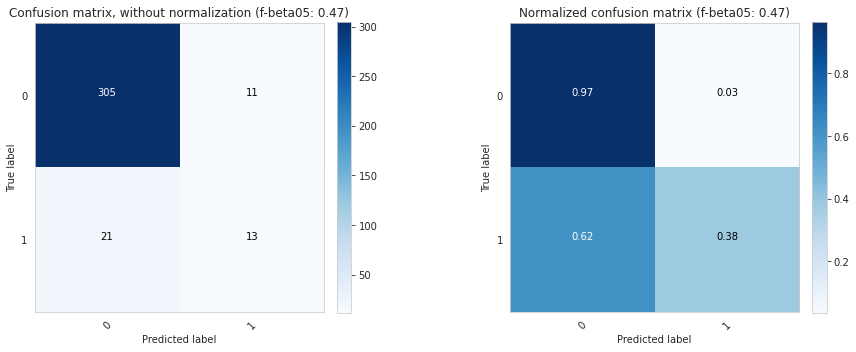

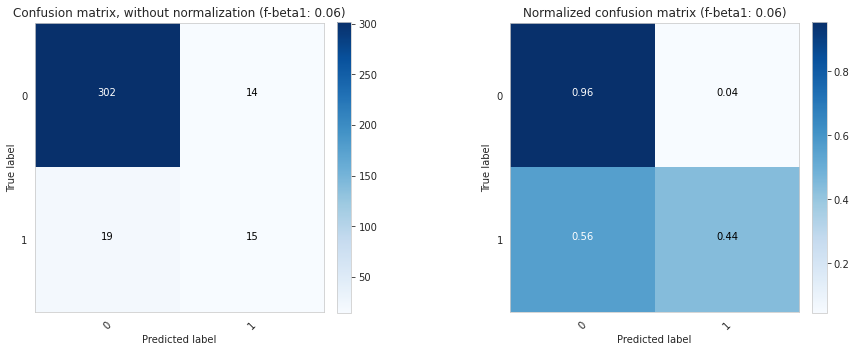

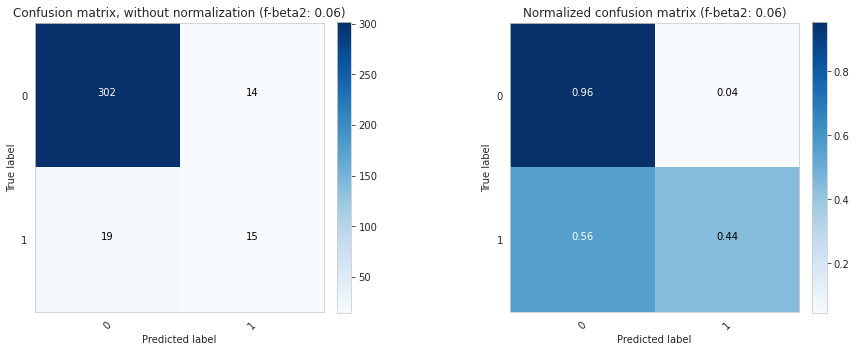



ROC Curve:


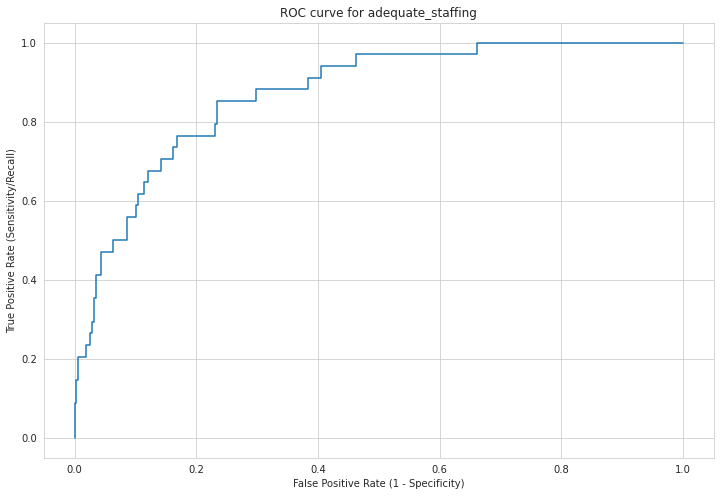

Predicted Probability Distribution:


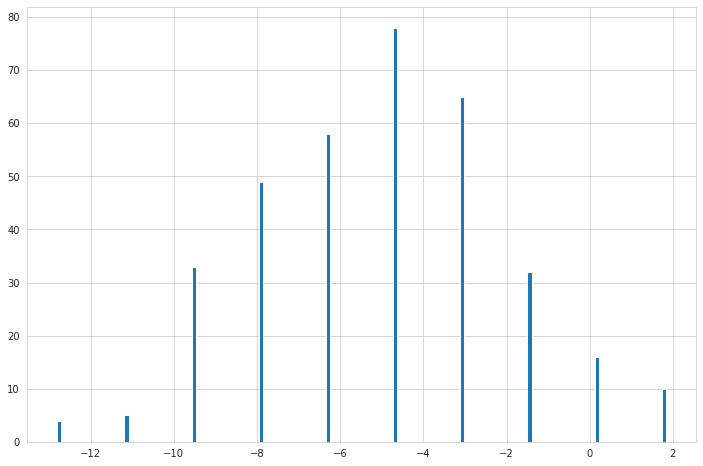



----------------------------------------------------------------------------------------------------


ADVANCEMENT_AND_TRAINING_OPPORTUNITIES

Null Accuracy:	0.9371428571428572
AUC Score:	0.8363359201773837

		f-beta05(0.47)		f-beta1(0.06)		f-beta2(0.06)
Accuracy:	0.9285714285714286	0.9257142857142857	0.9257142857142857	
Cohen's Kappa:	0.16299980868567054	0.15427509293680286	0.15427509293680286	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9443              0.9817              0.9626              328                 
1                   0.3333              0.1364              0.1935              22                  
avg/total           0.6388              0.559               0.5781              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9441              0.9787     

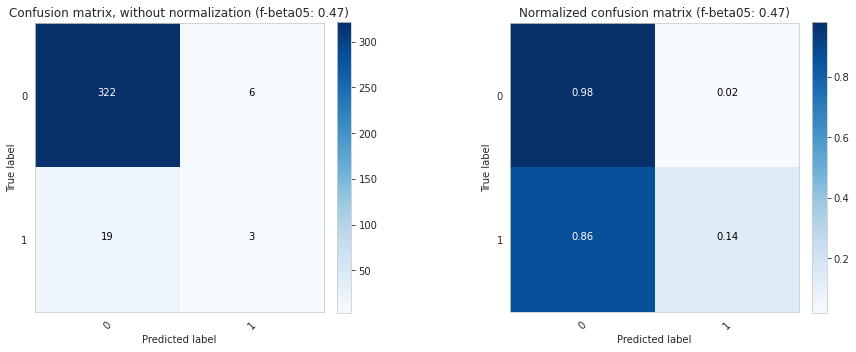

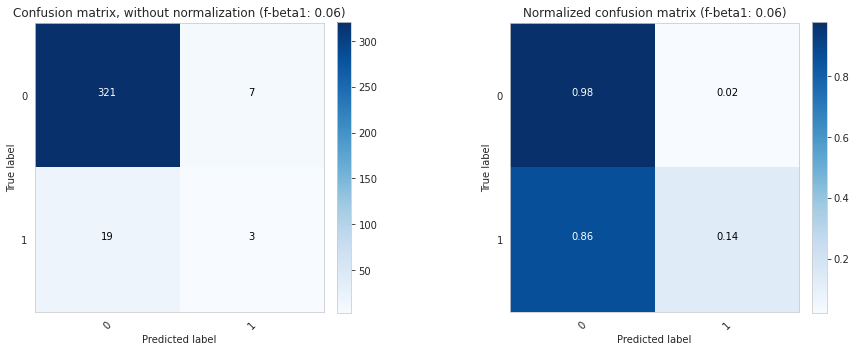

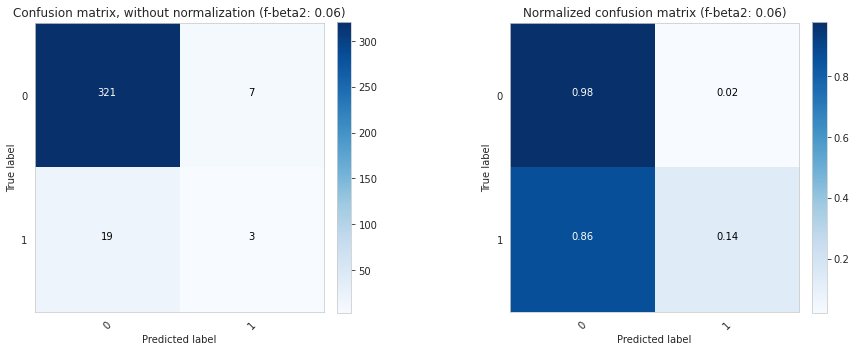



ROC Curve:


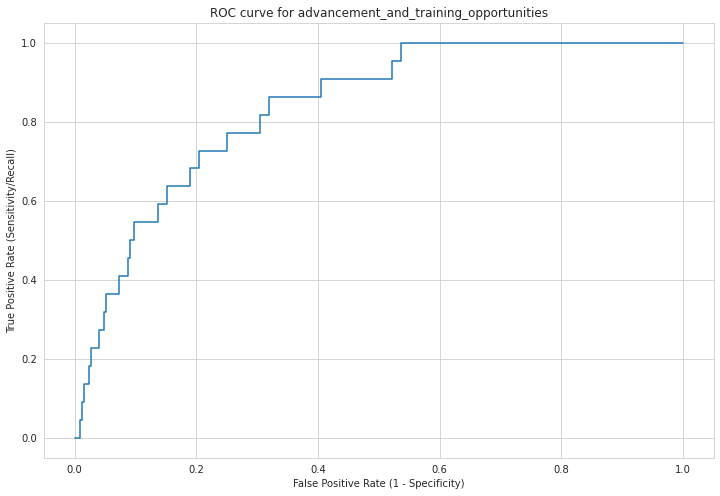

Predicted Probability Distribution:


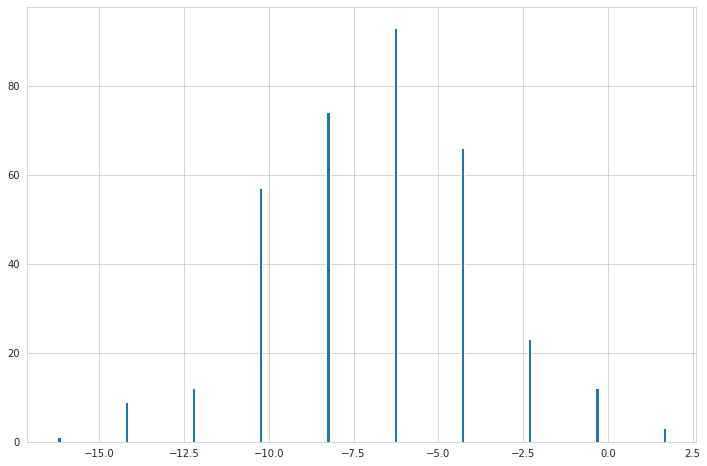



----------------------------------------------------------------------------------------------------


APPROPRIATE_STRESS_WORK_ASSIGNED_EQUITABLY

Null Accuracy:	0.92
AUC Score:	0.8071206743566992

		f-beta05(0.47)		f-beta1(0.06)		f-beta2(0.06)
Accuracy:	0.9085714285714286	0.9	0.9	
Cohen's Kappa:	0.15966386554621848	0.20382165605095548	0.20382165605095548	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.929               0.9752              0.9515              322                 
1                   0.3333              0.1429              0.2                 28                  
avg/total           0.6312              0.559               0.5758              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9335              0.9596              0.9464              322        

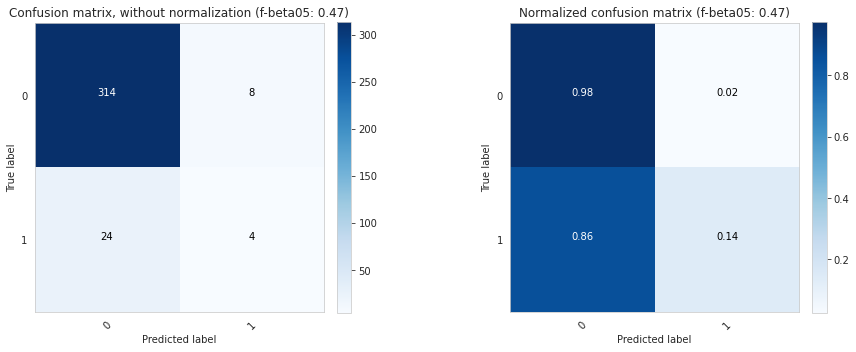

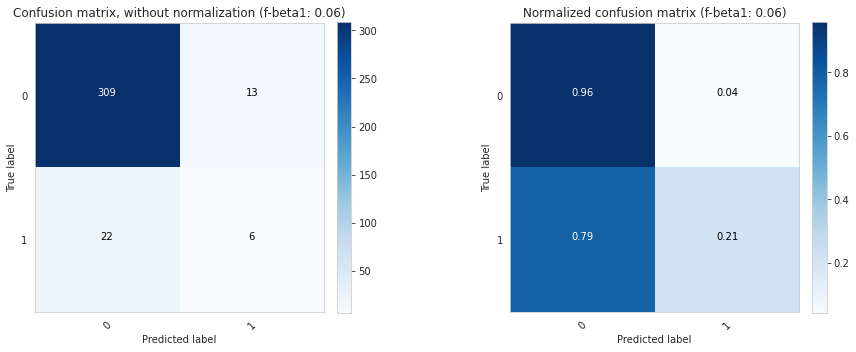

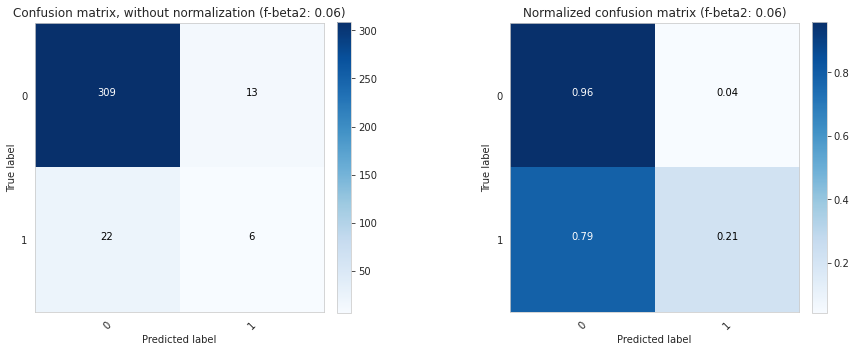



ROC Curve:


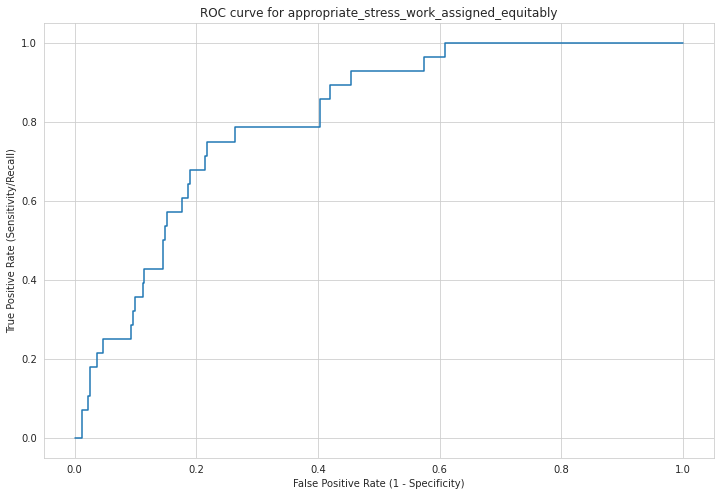

Predicted Probability Distribution:


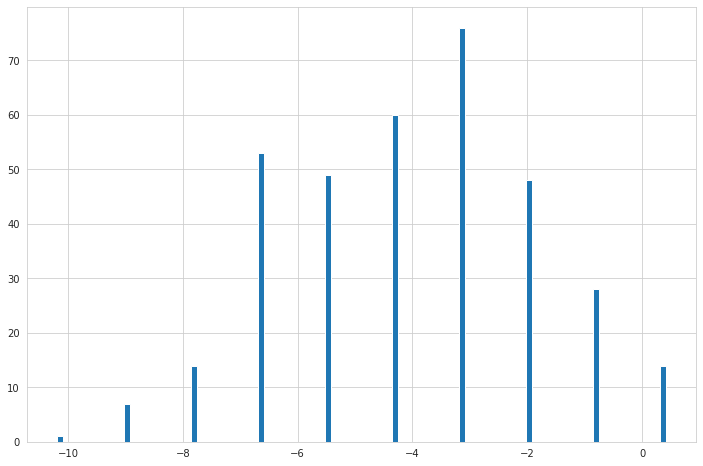



----------------------------------------------------------------------------------------------------


BENEFITS

Null Accuracy:	0.9742857142857143
AUC Score:	0.9393939393939394

		f-beta05(0.47)		f-beta1(0.06)		f-beta2(0.06)
Accuracy:	0.9742857142857143	0.9742857142857143	0.9742857142857143	
Cohen's Kappa:	0.29656096471639126	0.29656096471639126	0.29656096471639126	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9798              0.9941              0.9869              341                 
1                   0.5                 0.2222              0.3077              9                   
avg/total           0.7399              0.6082              0.6473              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9798              0.9941              0.9869              3

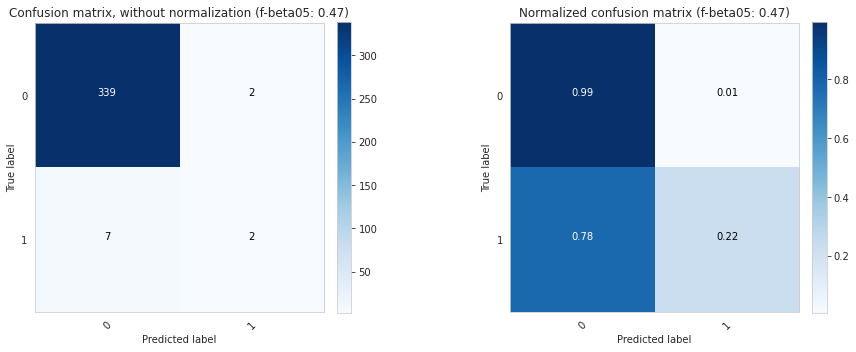

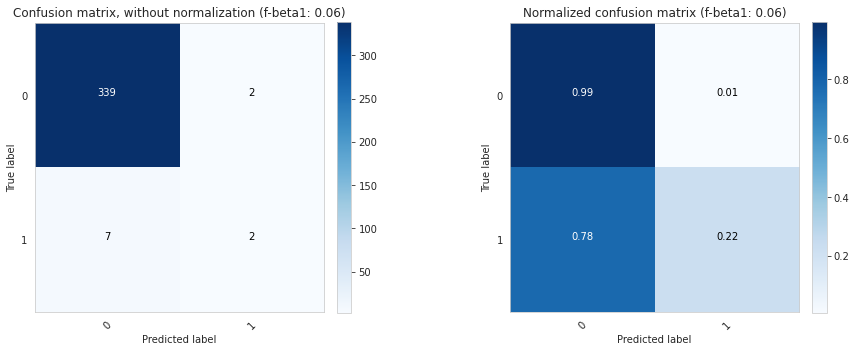

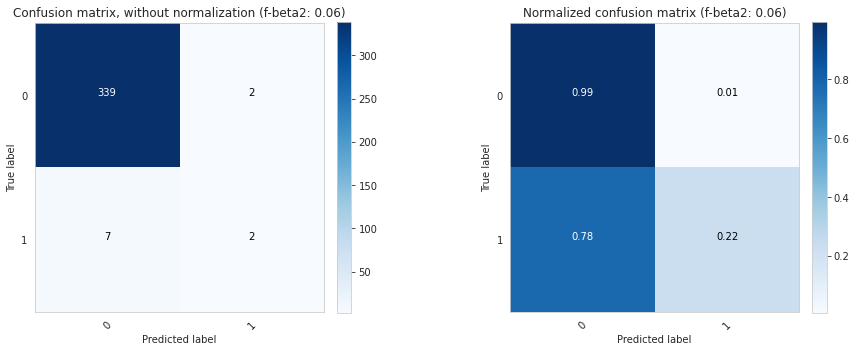



ROC Curve:


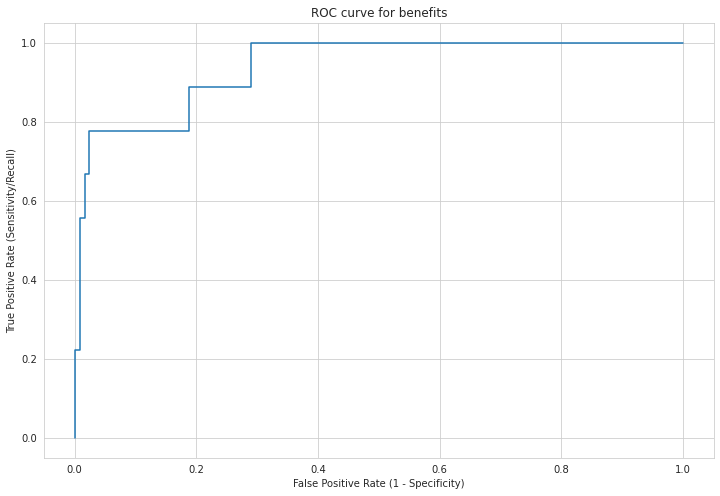

Predicted Probability Distribution:


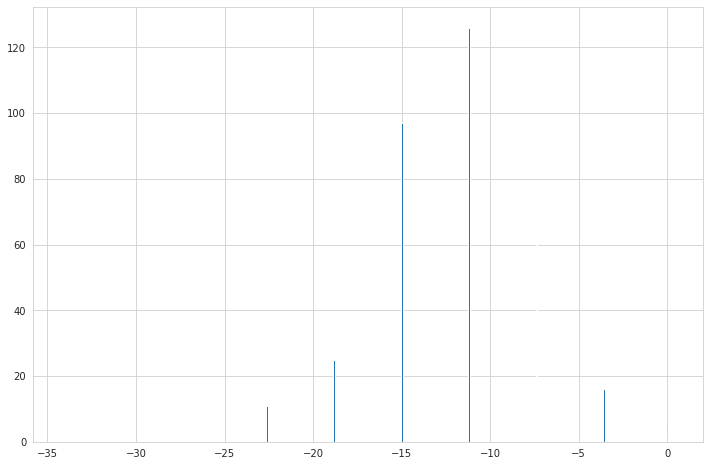



----------------------------------------------------------------------------------------------------


BETTER_WAYS_RECOGNIZED_PARTICIPATE_IN_DECISIONS

Null Accuracy:	0.9257142857142857
AUC Score:	0.8218186134852802

		f-beta05(0.47)		f-beta1(0.06)		f-beta2(0.06)
Accuracy:	0.9314285714285714	0.9285714285714286	0.9285714285714286	
Cohen's Kappa:	0.33733038813505845	0.35519528371407516	0.35519528371407516	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9438              0.9846              0.9637              324                 
1                   0.5833              0.2692              0.3684              26                  
avg/total           0.7636              0.6269              0.6661              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9463              0.

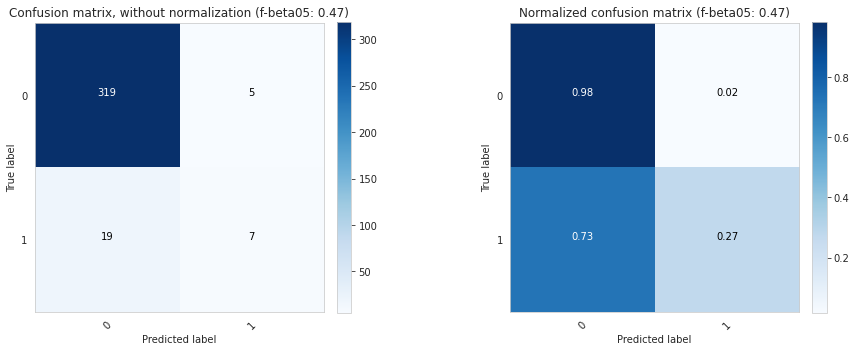

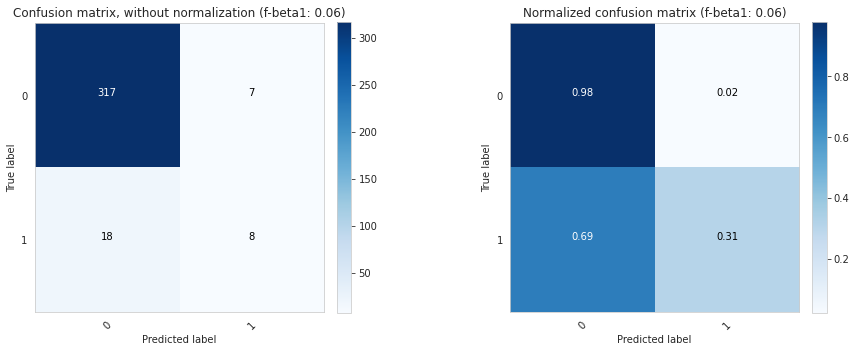

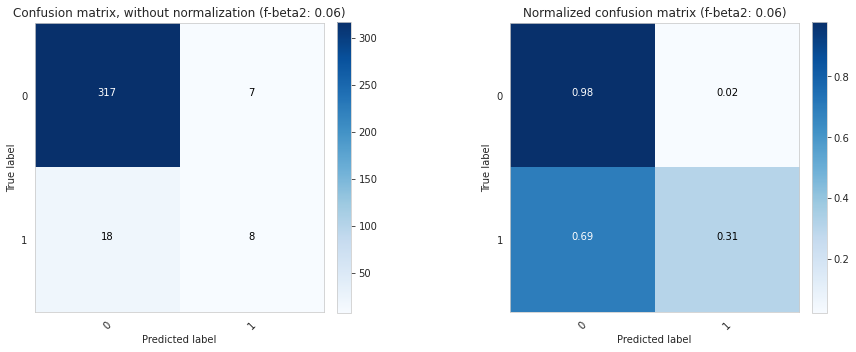



ROC Curve:


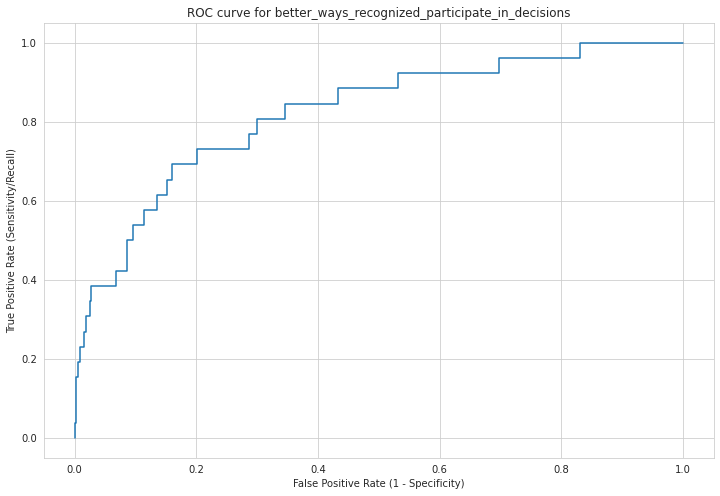

Predicted Probability Distribution:


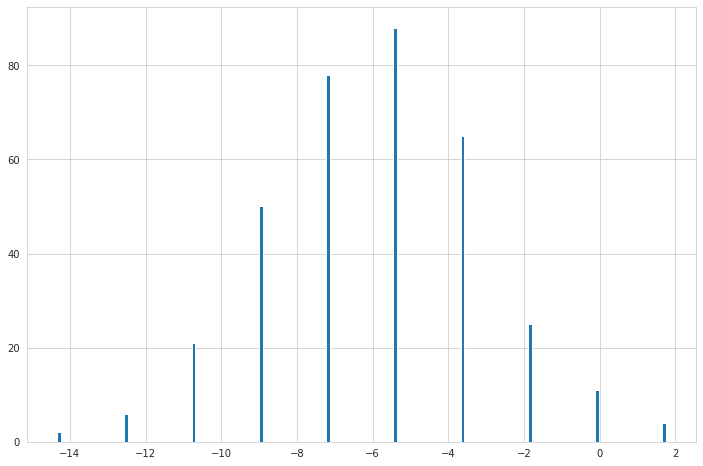



----------------------------------------------------------------------------------------------------


CAREER_ADVANCEMENT

Null Accuracy:	0.9342857142857143
AUC Score:	0.8263528786065683

		f-beta05(0.47)		f-beta1(0.06)		f-beta2(0.06)
Accuracy:	0.94	0.9342857142857143	0.9342857142857143	
Cohen's Kappa:	0.37168746794323815	0.3458475540386803	0.3458475540386803	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9527              0.9847              0.9684              327                 
1                   0.5833              0.3043              0.4                 23                  
avg/total           0.768               0.6445              0.6842              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9524              0.9786              0.9653              327    

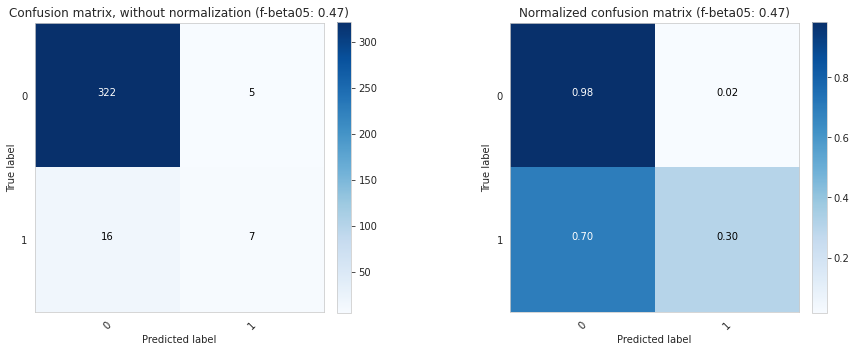

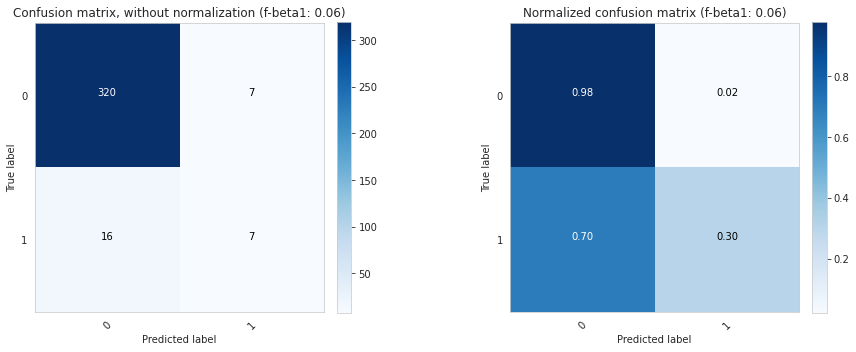

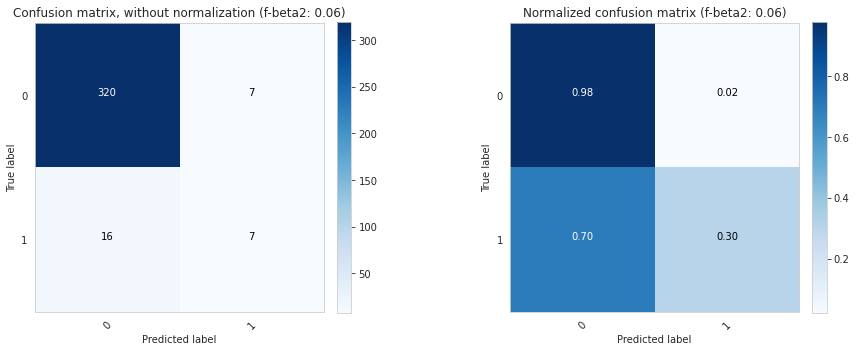



ROC Curve:


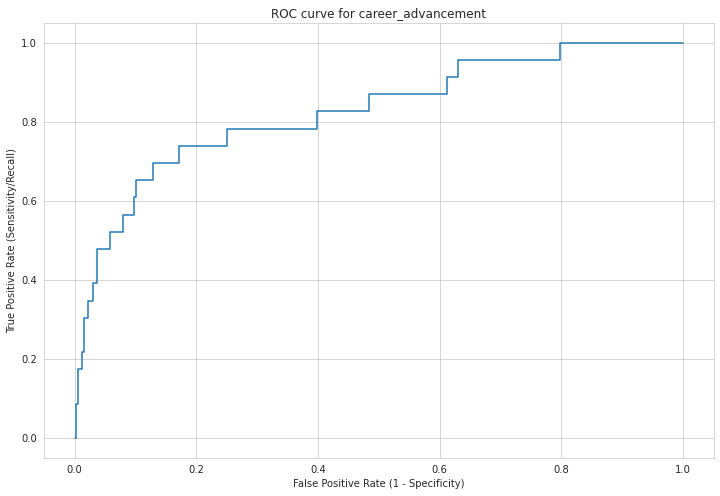

Predicted Probability Distribution:


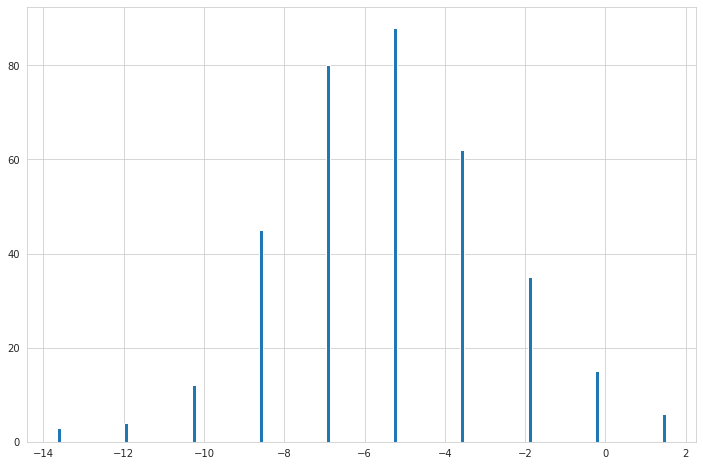



----------------------------------------------------------------------------------------------------


COMMITTED_TO_DIVERSITY

Null Accuracy:	0.9457142857142857
AUC Score:	0.838289076164732

		f-beta05(0.47)		f-beta1(0.06)		f-beta2(0.06)
Accuracy:	0.9171428571428571	0.9142857142857143	0.9142857142857143	
Cohen's Kappa:	0.12815667411097753	0.16520909524566707	0.16520909524566707	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9521              0.9607              0.9564              331                 
1                   0.1875              0.1579              0.1714              19                  
avg/total           0.5698              0.5593              0.5639              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9547              0.9547              0.9547  

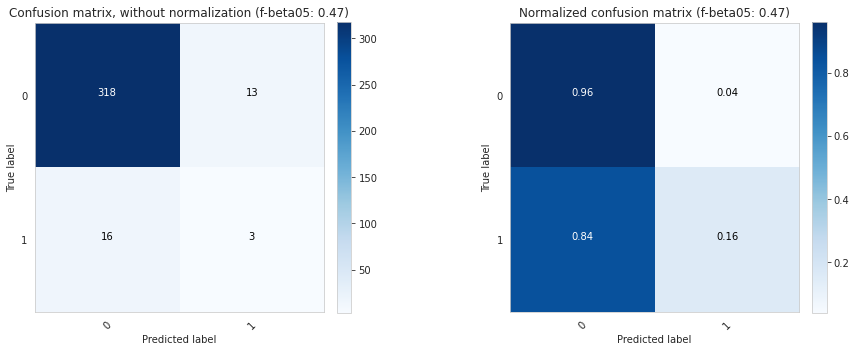

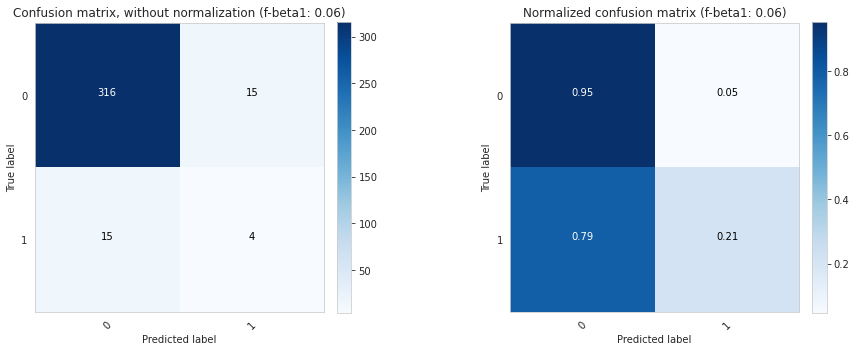

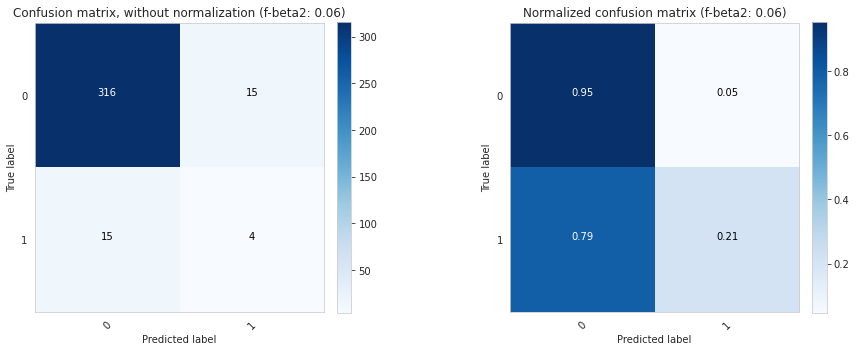



ROC Curve:


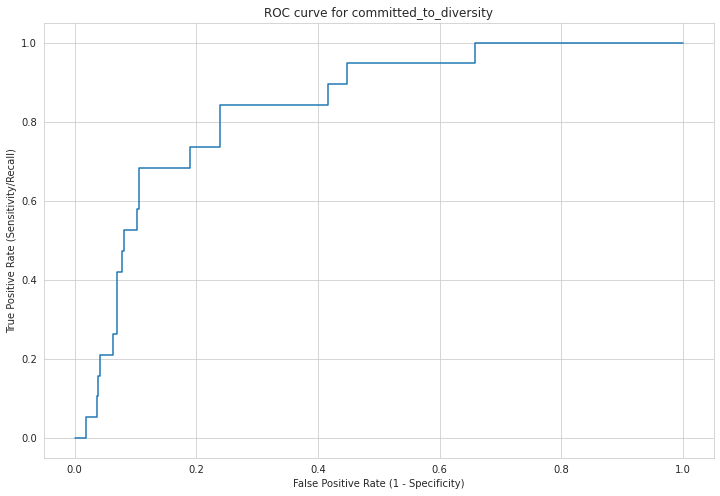

Predicted Probability Distribution:


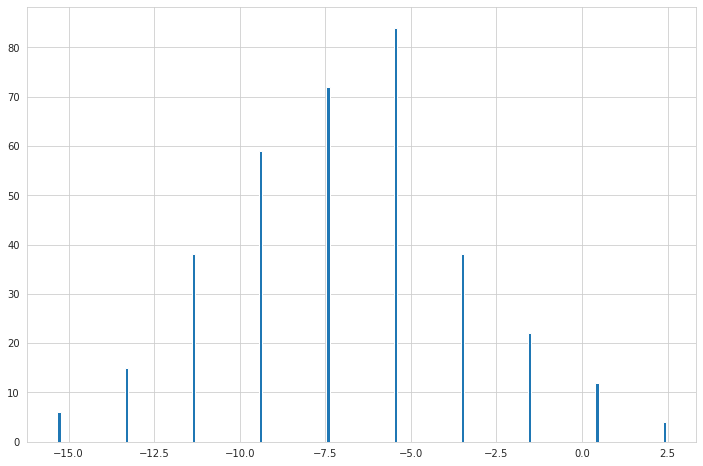



----------------------------------------------------------------------------------------------------


COMMUNICATES_ESSENTIAL_INFORMATION

Null Accuracy:	0.9685714285714285
AUC Score:	0.9048002145347277

		f-beta05(0.47)		f-beta1(0.06)		f-beta2(0.06)
Accuracy:	0.9771428571428571	0.9771428571428571	0.9771428571428571	
Cohen's Kappa:	0.6549174266699531	0.6549174266699531	0.6549174266699531	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9911              0.9853              0.9882              339                 
1                   0.6154              0.7273              0.6667              11                  
avg/total           0.8032              0.8563              0.8274              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9911              0.9853            

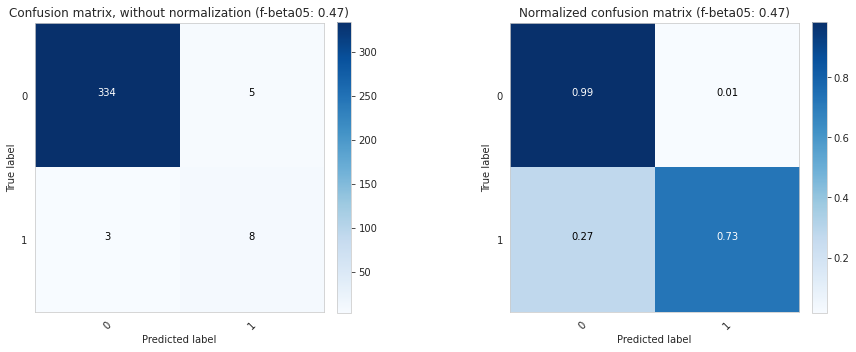

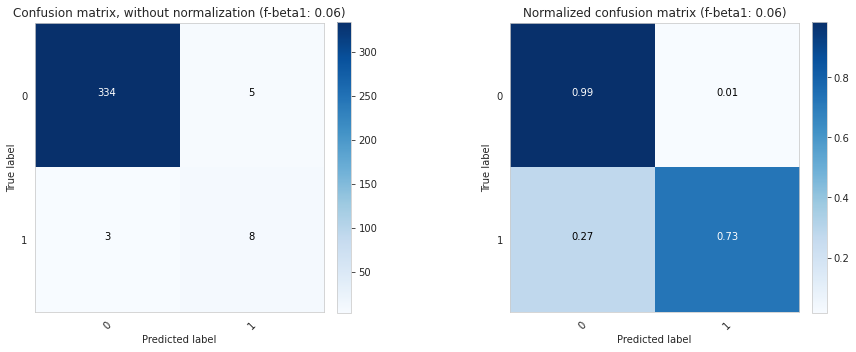

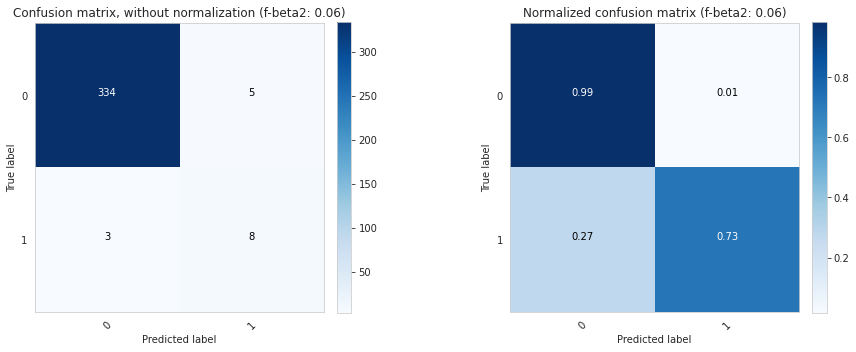



ROC Curve:


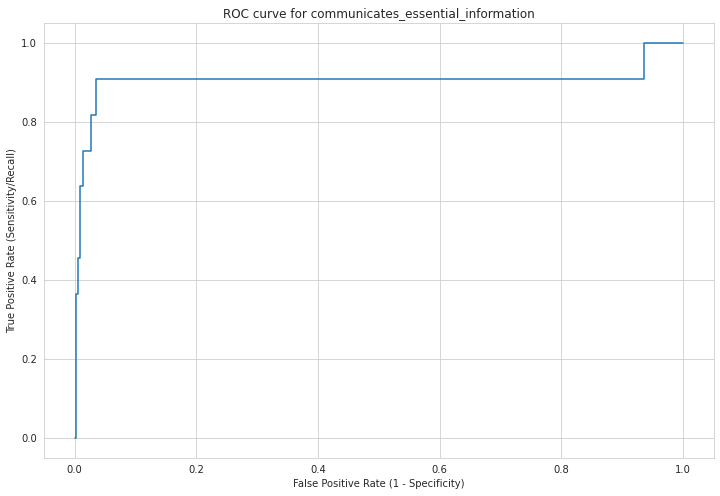

Predicted Probability Distribution:


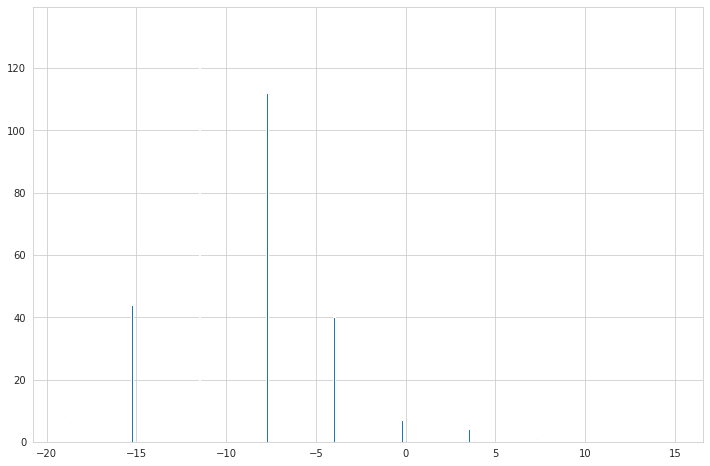



----------------------------------------------------------------------------------------------------


ETHICAL_CONDUCT_PERFORM_RESPONSIBILITIES_SPIRIT_OF_COOPERATION

Null Accuracy:	0.8742857142857143
AUC Score:	0.8198900772430184

		f-beta05(0.47)		f-beta1(0.06)		f-beta2(0.06)
Accuracy:	0.8742857142857143	0.88	0.88	
Cohen's Kappa:	0.11979881115683588	0.2290748898678414	0.2290748898678414	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.883               0.9869              0.9321              306                 
1                   0.5                 0.0909              0.1538              44                  
avg/total           0.6915              0.5389              0.543               350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.8929              0.9804           

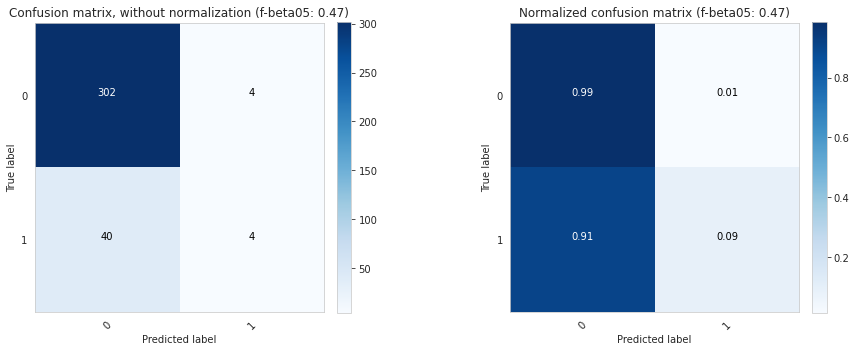

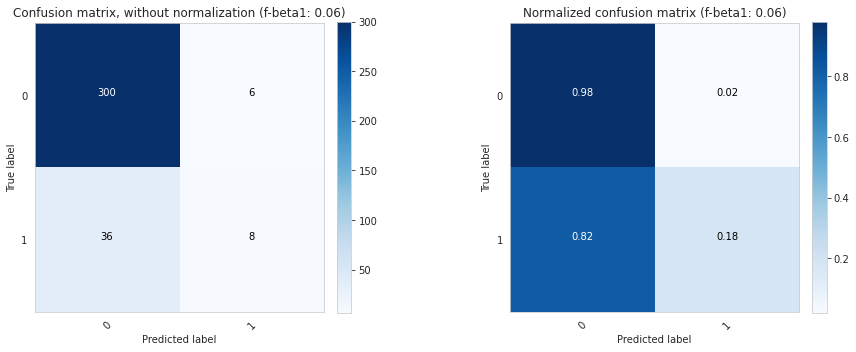

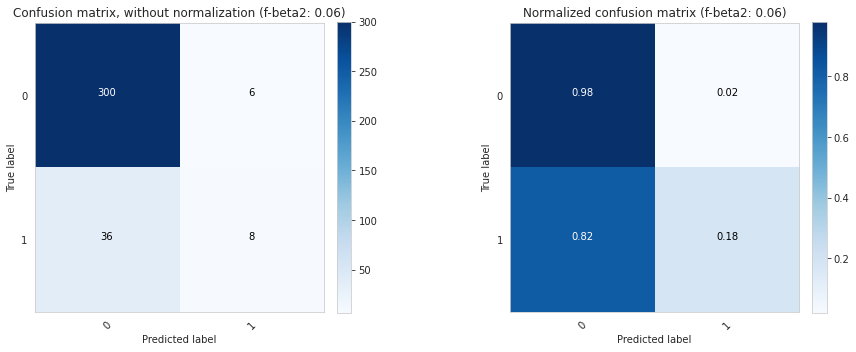



ROC Curve:


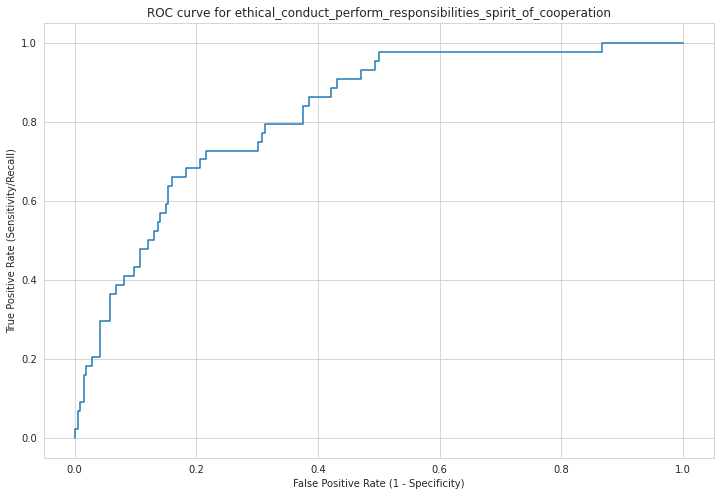

Predicted Probability Distribution:


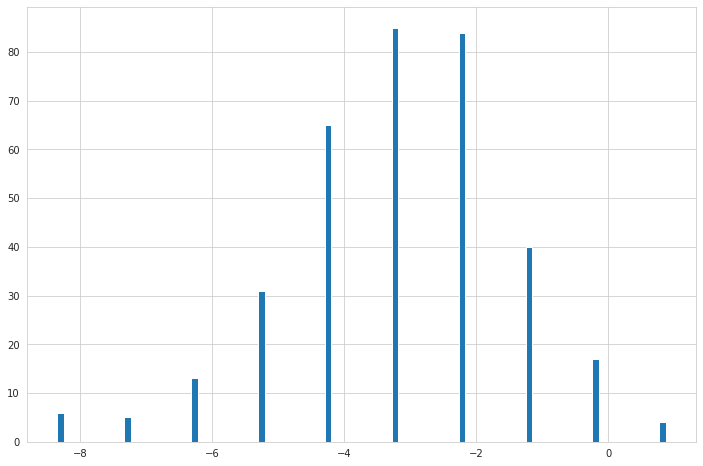



----------------------------------------------------------------------------------------------------


EVALUATED_FAIRLY

Null Accuracy:	0.9714285714285714
AUC Score:	0.7908823529411765

		f-beta05(0.47)		f-beta1(0.06)		f-beta2(0.06)
Accuracy:	0.9657142857142857	0.9628571428571429	0.9628571428571429	
Cohen's Kappa:	-0.009615384615384581	-0.013363028953229383	-0.013363028953229383	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9713              0.9941              0.9826              340                 
1                   0.0                 0.0                 0.0                 10                  
avg/total           0.4856              0.4971              0.4913              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9712              0.9912              0.9811 

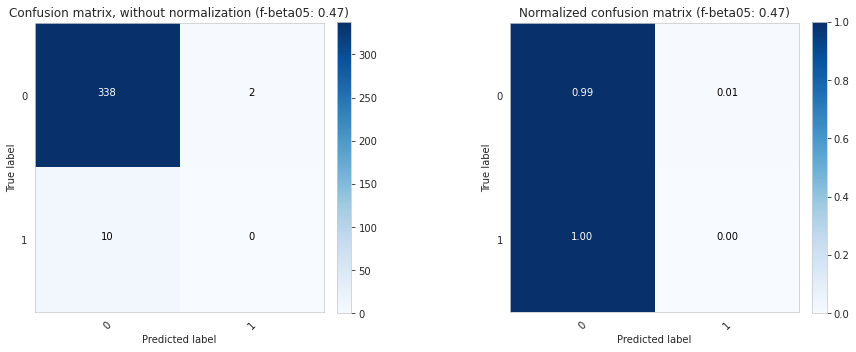

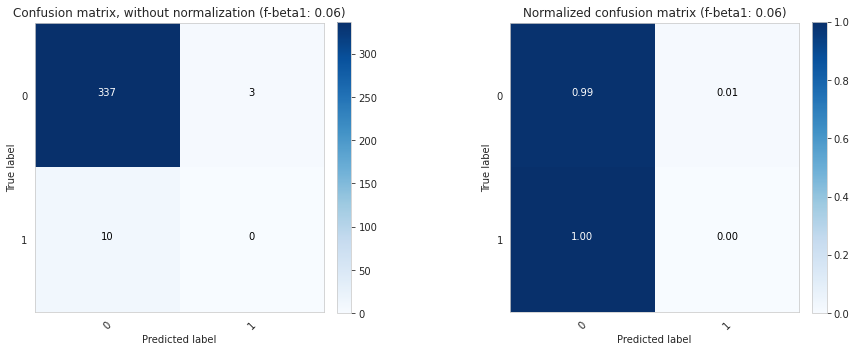

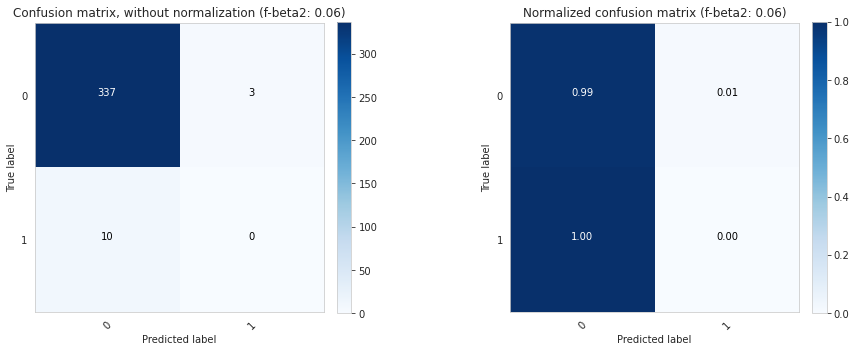



ROC Curve:


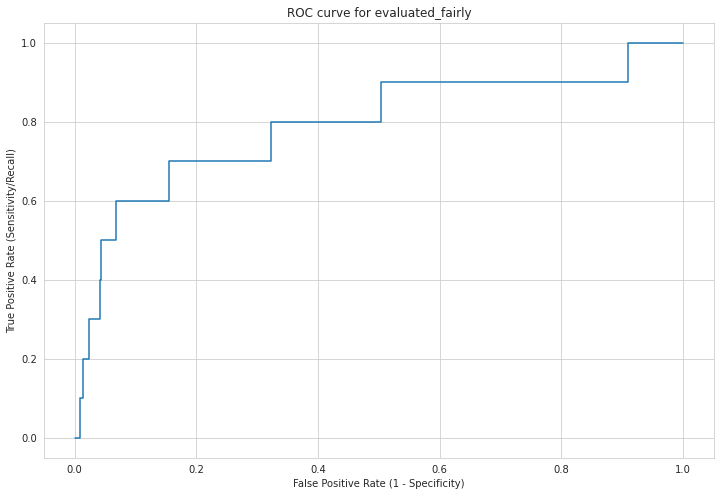

Predicted Probability Distribution:


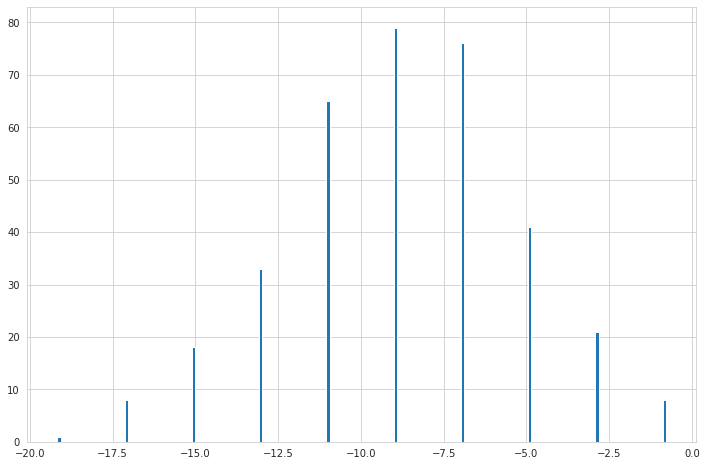



----------------------------------------------------------------------------------------------------


EXPERIENCED_DISCRIMINATION

Null Accuracy:	0.9028571428571428
AUC Score:	0.8095681310498883

		f-beta05(0.47)		f-beta1(0.06)		f-beta2(0.06)
Accuracy:	0.9114285714285715	0.9085714285714286	0.9085714285714286	
Cohen's Kappa:	0.37130606095723717	0.3813521873619089	0.3813521873619089	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9305              0.9747              0.9521              316                 
1                   0.5789              0.3235              0.4151              34                  
avg/total           0.7547              0.6491              0.6836              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9329              0.9684              0.950

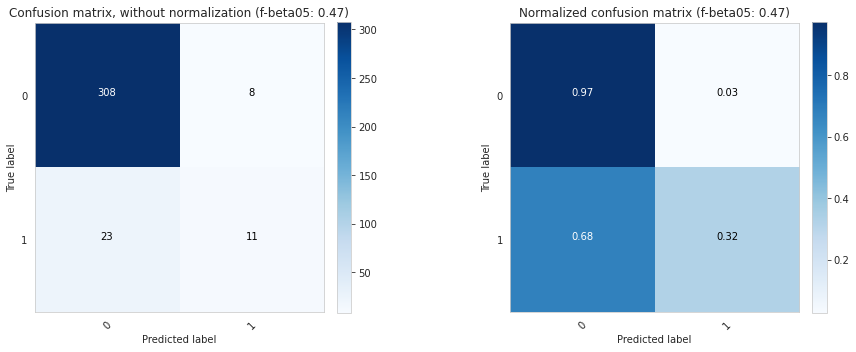

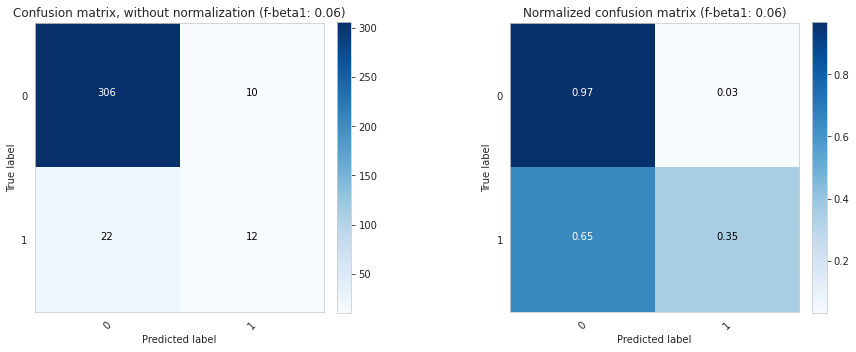

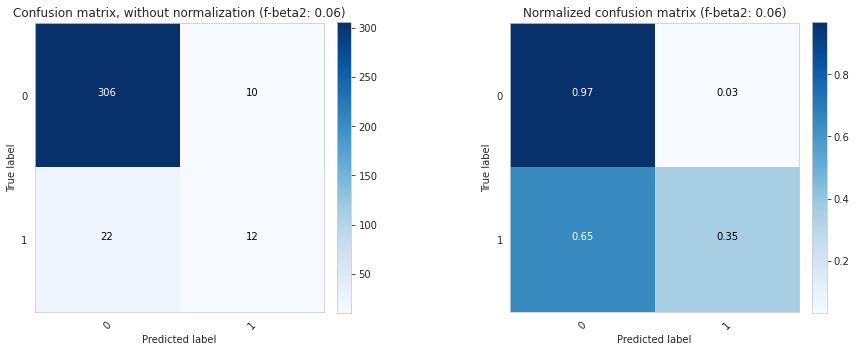



ROC Curve:


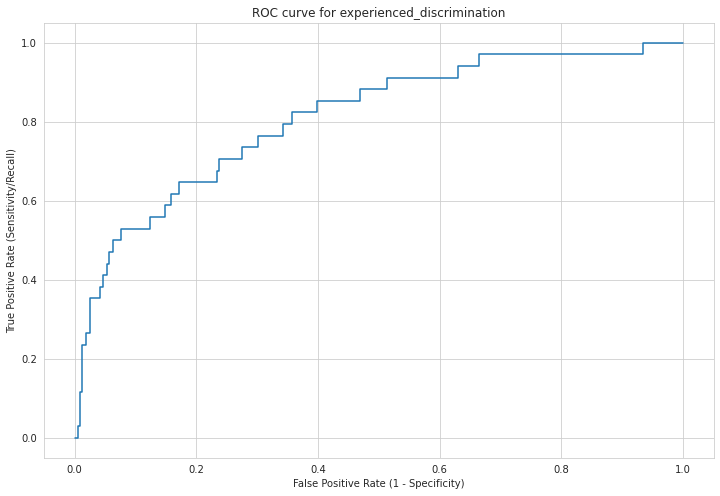

Predicted Probability Distribution:


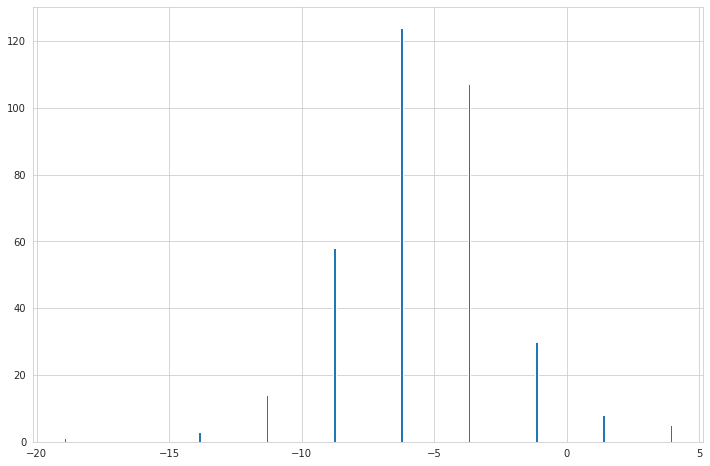



----------------------------------------------------------------------------------------------------


FACILITIES_WORKSPACE_SAFETY

Null Accuracy:	0.96
AUC Score:	0.844812925170068

		f-beta05(0.47)		f-beta1(0.06)		f-beta2(0.06)
Accuracy:	0.9657142857142857	0.96	0.96	
Cohen's Kappa:	0.48275862068965514	0.4408945686900958	0.4408945686900958	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9765              0.9881              0.9822              336                 
1                   0.6                 0.4286              0.5                 14                  
avg/total           0.7882              0.7083              0.7411              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9763              0.9821              0.9792              336                 
1     

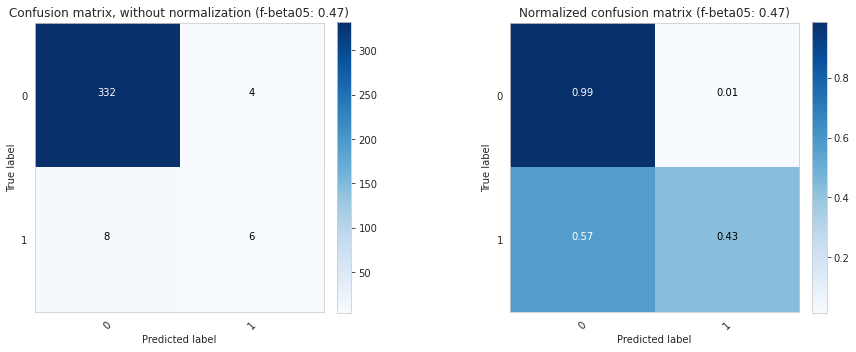

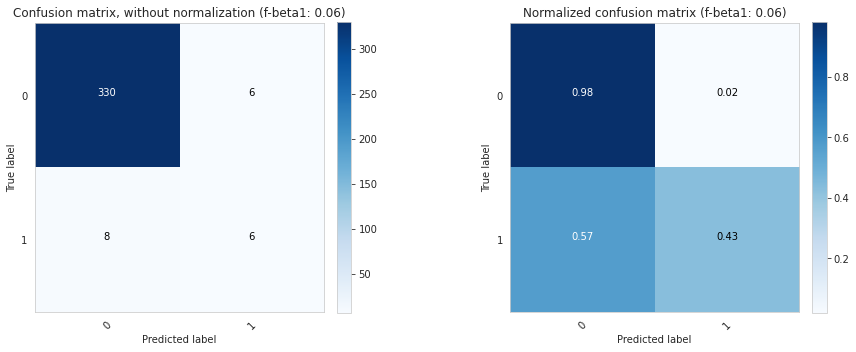

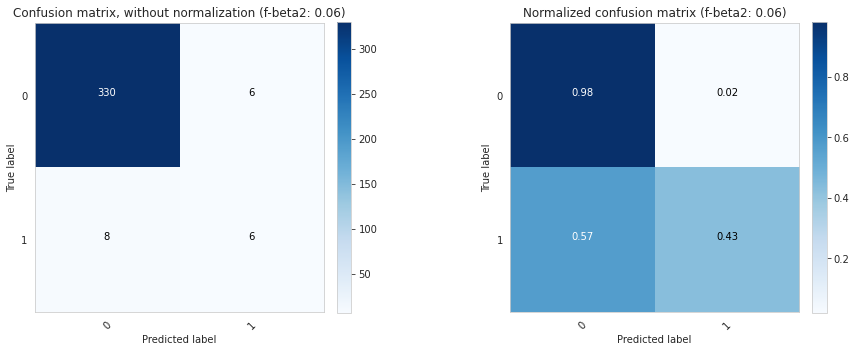



ROC Curve:


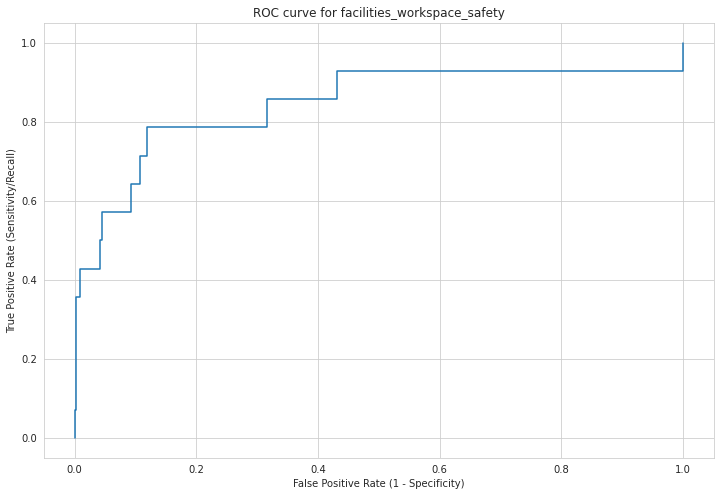

Predicted Probability Distribution:


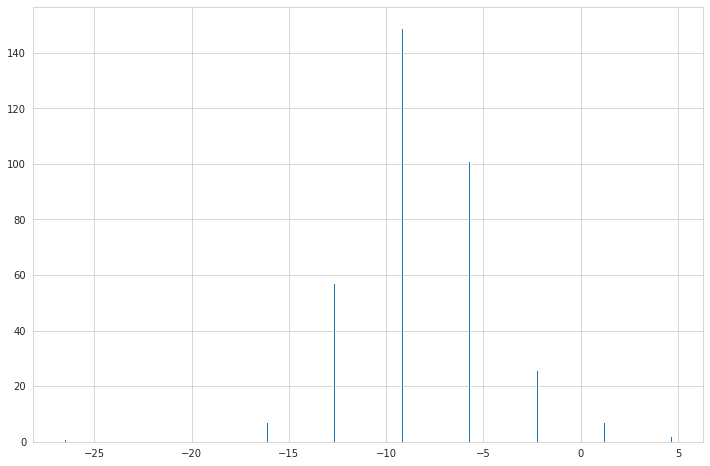



----------------------------------------------------------------------------------------------------


FACULTY_VALUE_CONTRIBUTIONS

Null Accuracy:	0.8857142857142857
AUC Score:	0.7604032258064517

		f-beta05(0.47)		f-beta1(0.06)		f-beta2(0.06)
Accuracy:	0.8885714285714286	0.8771428571428571	0.8771428571428571	
Cohen's Kappa:	0.30604982206405695	0.27469879518072293	0.27469879518072293	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9119              0.9677              0.939               310                 
1                   0.5238              0.275               0.3607              40                  
avg/total           0.7178              0.6214              0.6498              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9108              0.9548              0.

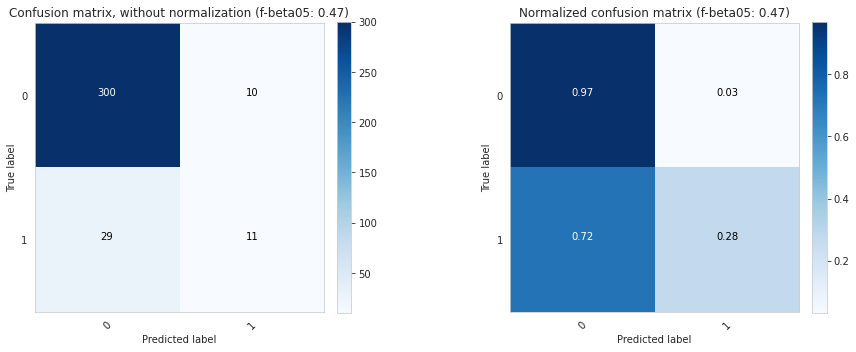

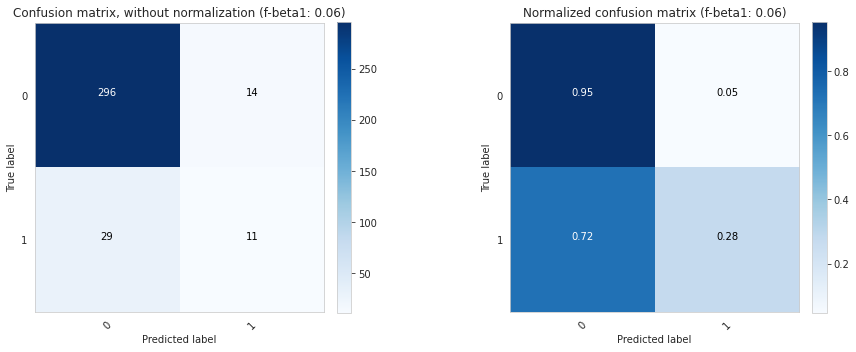

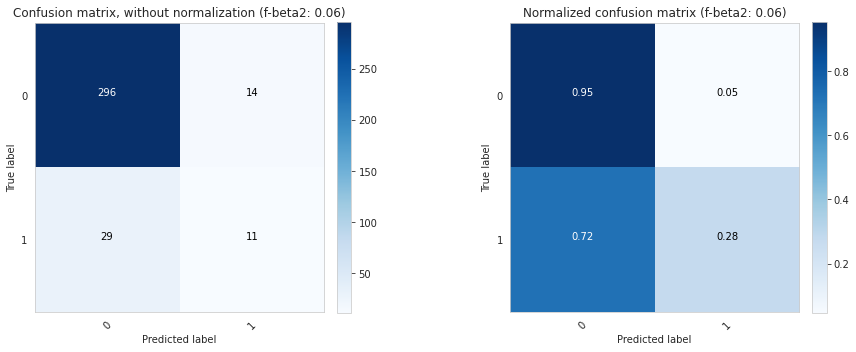



ROC Curve:


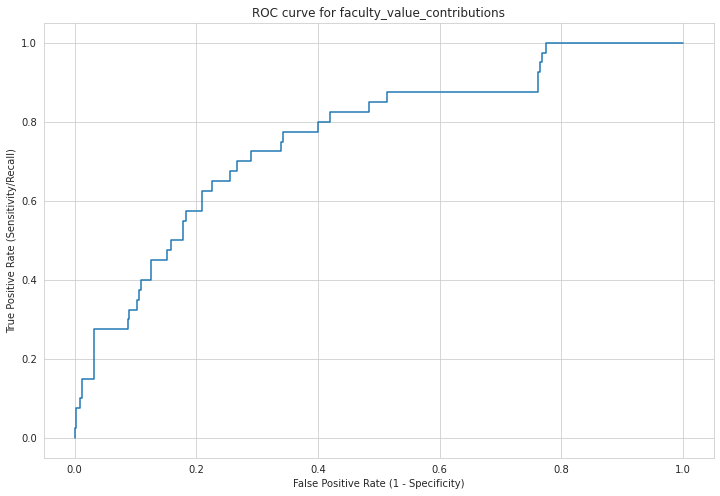

Predicted Probability Distribution:


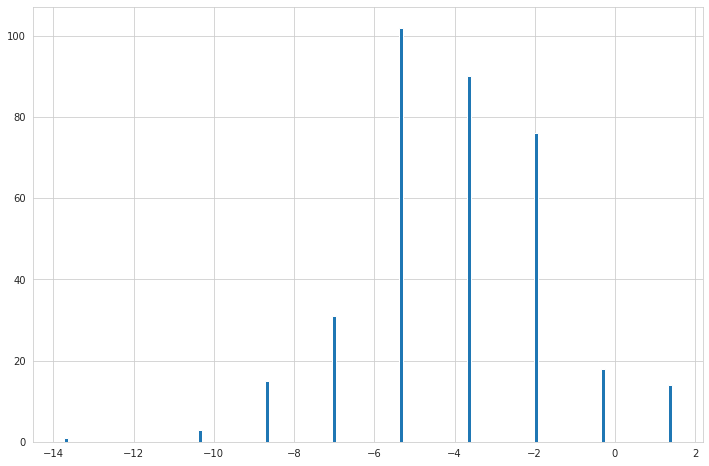



----------------------------------------------------------------------------------------------------


FAVORITISM_CLIQUES

Null Accuracy:	0.9685714285714285
AUC Score:	0.8087959238401716

		f-beta05(0.47)		f-beta1(0.06)		f-beta2(0.06)
Accuracy:	0.9657142857142857	0.9628571428571429	0.9628571428571429	
Cohen's Kappa:	0.13115432354158052	0.11855869817900033	0.11855869817900033	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9712              0.9941              0.9825              339                 
1                   0.3333              0.0909              0.1429              11                  
avg/total           0.6523              0.5425              0.5627              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9711              0.9912              0.981      

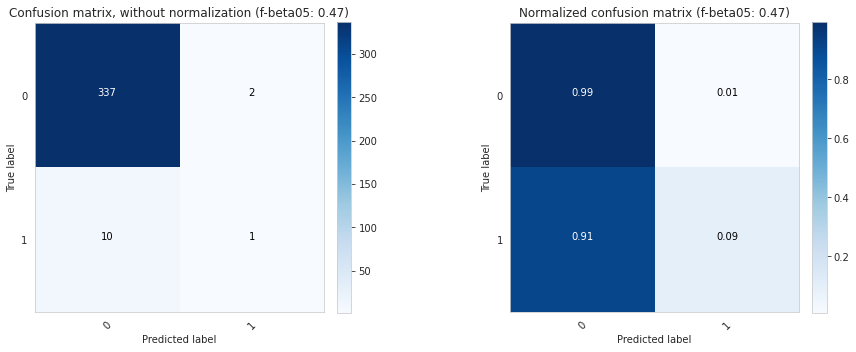

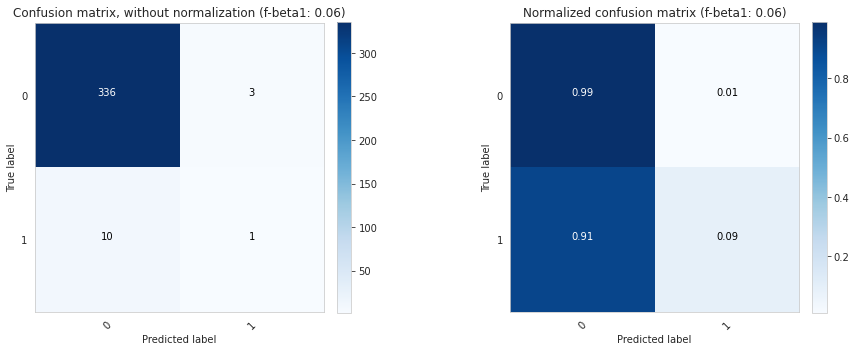

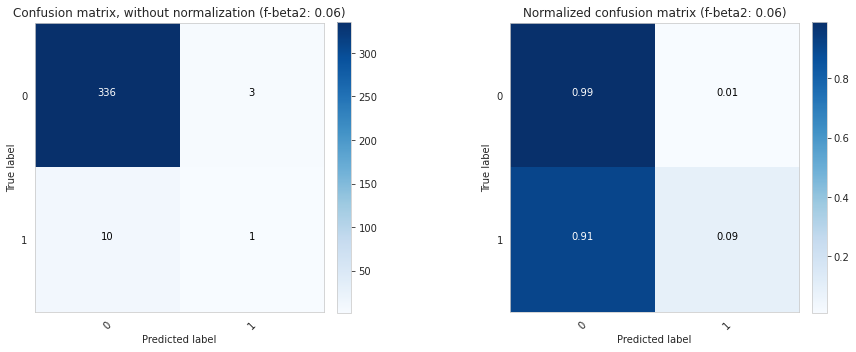



ROC Curve:


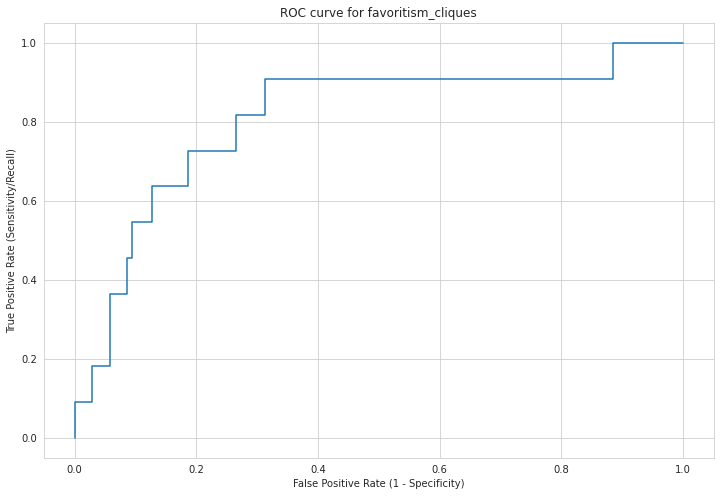

Predicted Probability Distribution:


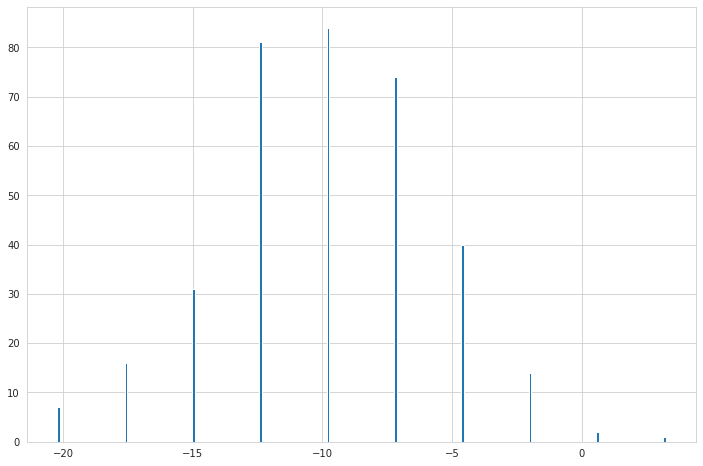



----------------------------------------------------------------------------------------------------


FEAR_OF_RETALIATION_NEGATIVE_CONSEQUENCES

Null Accuracy:	0.8771428571428571
AUC Score:	0.8615256419968184

		f-beta05(0.47)		f-beta1(0.06)		f-beta2(0.06)
Accuracy:	0.8942857142857142	0.8828571428571429	0.8828571428571429	
Cohen's Kappa:	0.3281104078032583	0.3120145747435037	0.3120145747435037	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9042              0.9837              0.9423              307                 
1                   0.6875              0.2558              0.3729              43                  
avg/total           0.7958              0.6198              0.6576              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9055              0.9674     

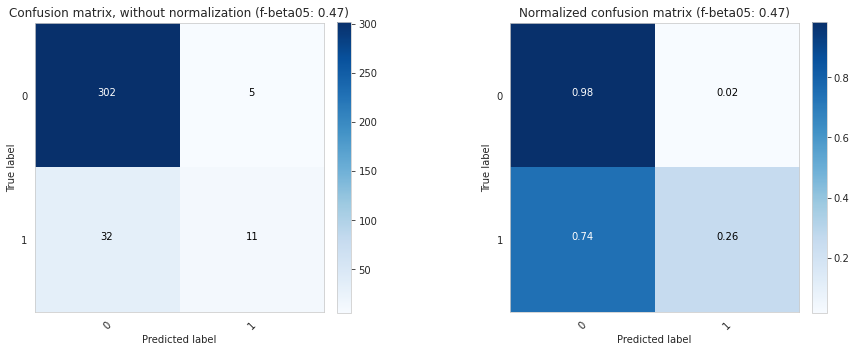

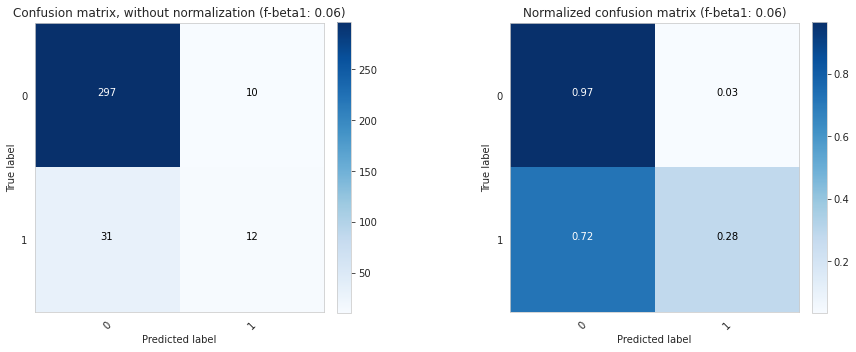

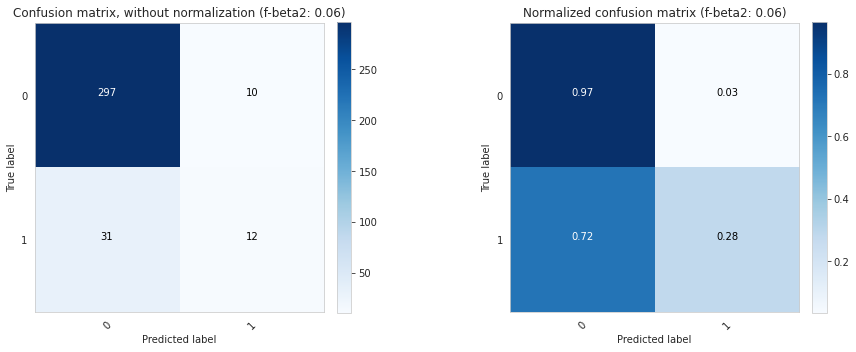



ROC Curve:


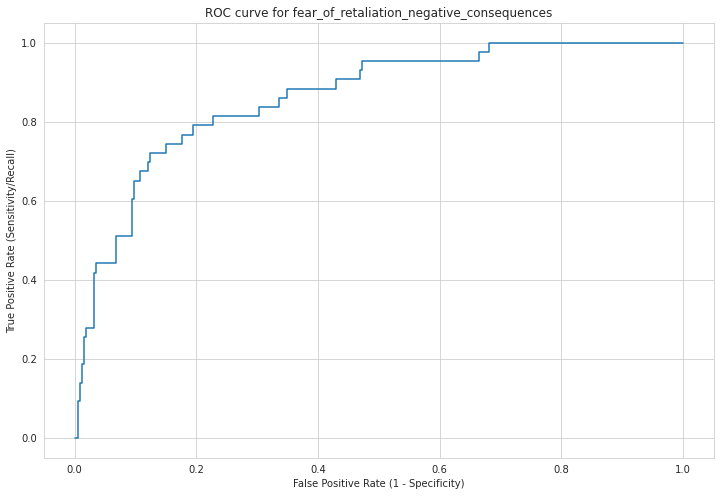

Predicted Probability Distribution:


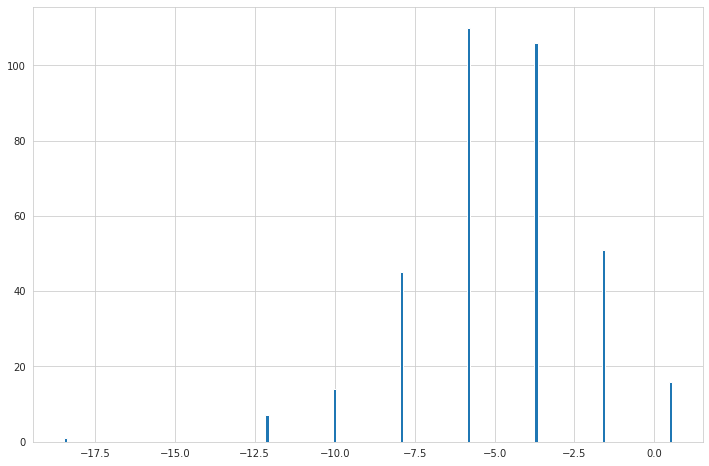



----------------------------------------------------------------------------------------------------


FEEL_VALUED_BY_DEPARTMENT

Null Accuracy:	0.8971428571428571
AUC Score:	0.7062986553432412

		f-beta05(0.47)		f-beta1(0.06)		f-beta2(0.06)
Accuracy:	0.8942857142857142	0.88	0.88	
Cohen's Kappa:	0.252568394320674	0.23723536737235362	0.23723536737235362	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9159              0.9713              0.9428              314                 
1                   0.4706              0.2222              0.3019              36                  
avg/total           0.6933              0.5968              0.6223              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9172              0.9522              0.9344              314           

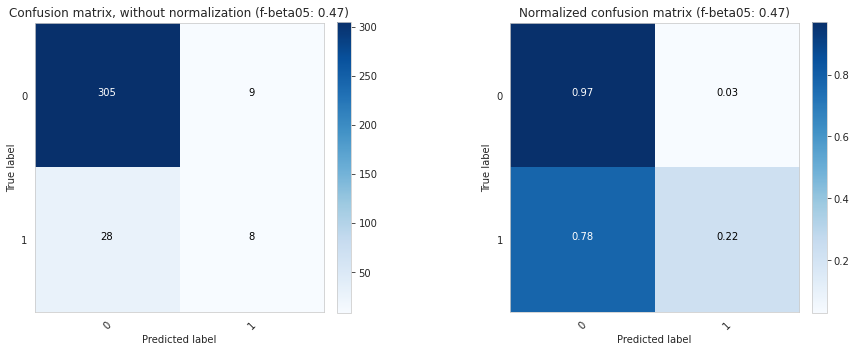

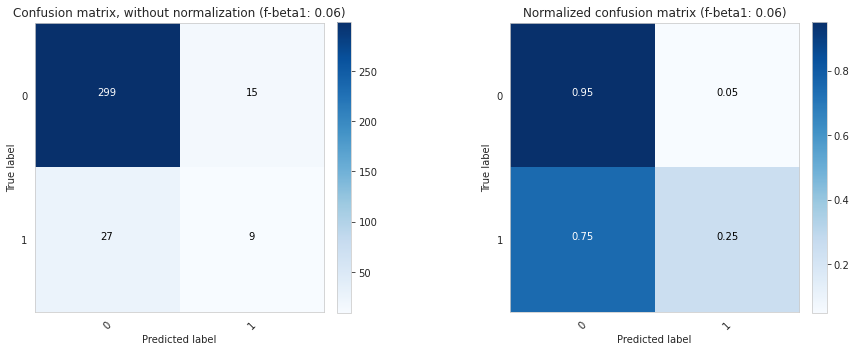

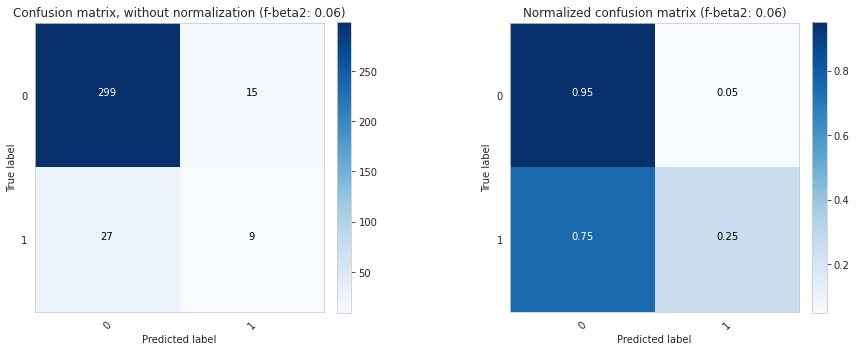



ROC Curve:


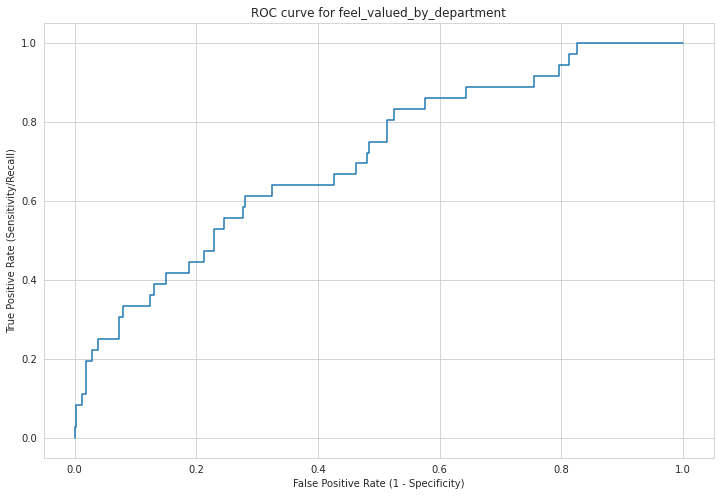

Predicted Probability Distribution:


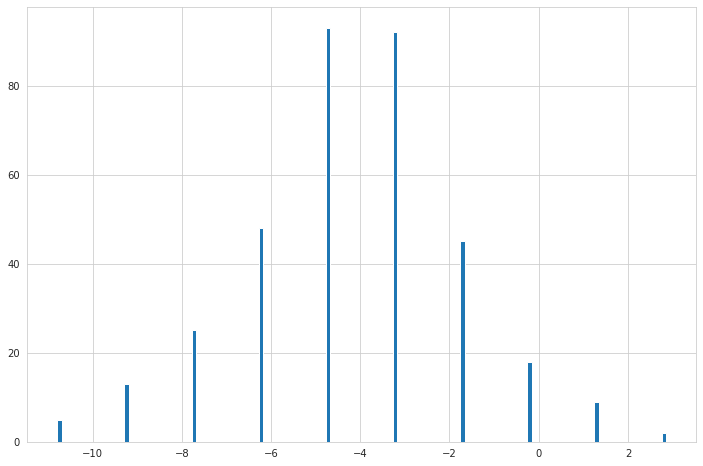



----------------------------------------------------------------------------------------------------


FLEXIBILITY_WORK_LIFE_BALANCE

Null Accuracy:	0.9628571428571429
AUC Score:	0.9059575439397398

		f-beta05(0.47)		f-beta1(0.06)		f-beta2(0.06)
Accuracy:	0.9685714285714285	0.9657142857142857	0.9657142857142857	
Cohen's Kappa:	0.5437307418819626	0.5206573841588679	0.5206573841588679	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9822              0.9852              0.9837              337                 
1                   0.5833              0.5385              0.56                13                  
avg/total           0.7828              0.7618              0.7719              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9822              0.9822              0.9

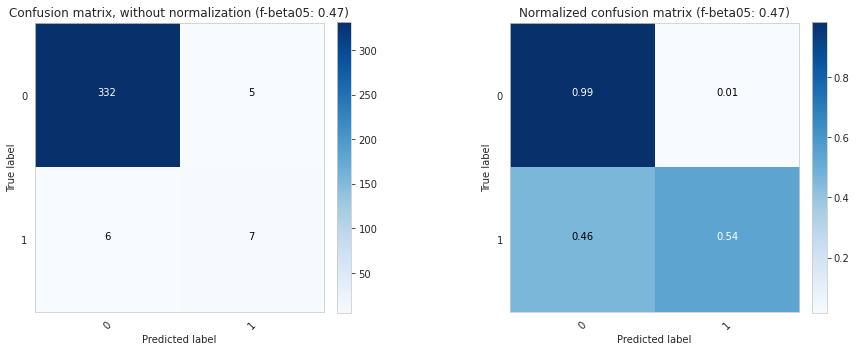

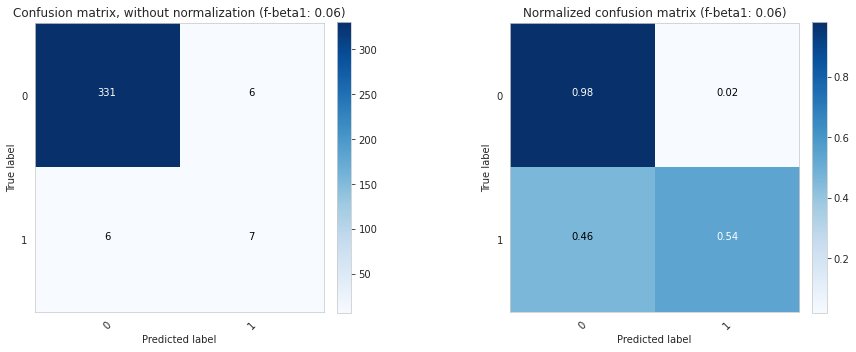

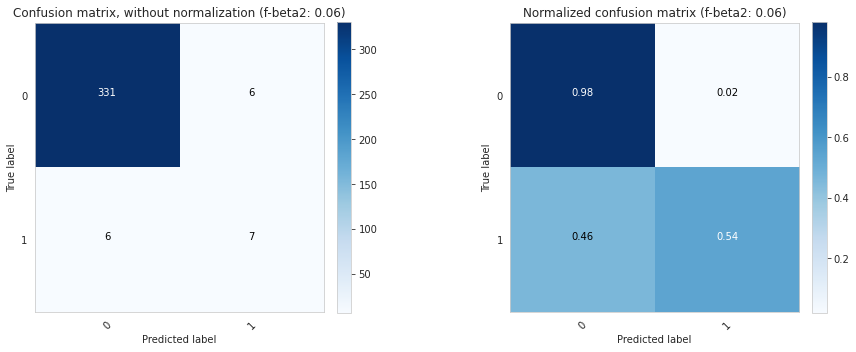



ROC Curve:


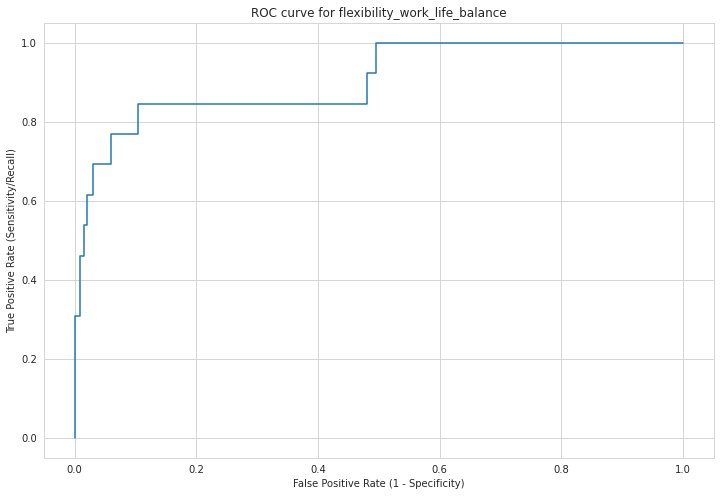

Predicted Probability Distribution:


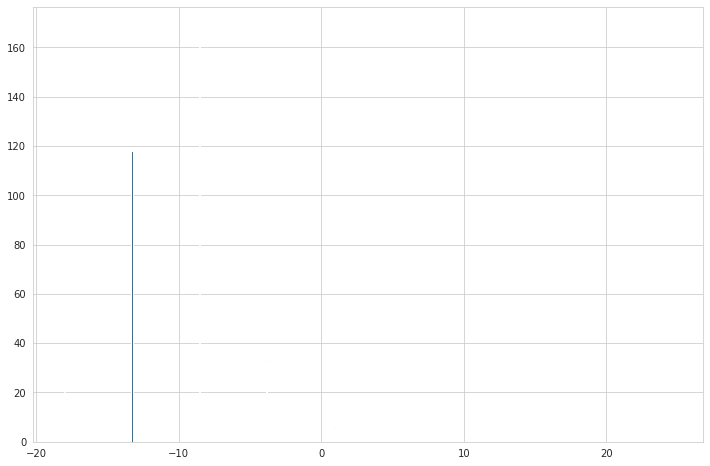



----------------------------------------------------------------------------------------------------


GOOD_USE_OF_SKILLS

Null Accuracy:	0.98
AUC Score:	0.7255310287380258

		f-beta05(0.47)		f-beta1(0.06)		f-beta2(0.06)
Accuracy:	0.98	0.9714285714285714	0.9714285714285714	
Cohen's Kappa:	0.0	-0.012145748987854255	-0.012145748987854255	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.98                1.0                 0.9899              343                 
1                   0.0                 0.0                 0.0                 7                   
avg/total           0.49                0.5                 0.4949              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9798              0.9913              0.9855              343                 
1         

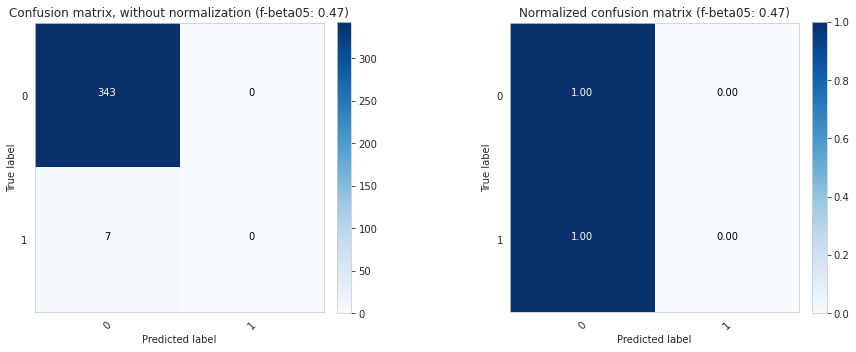

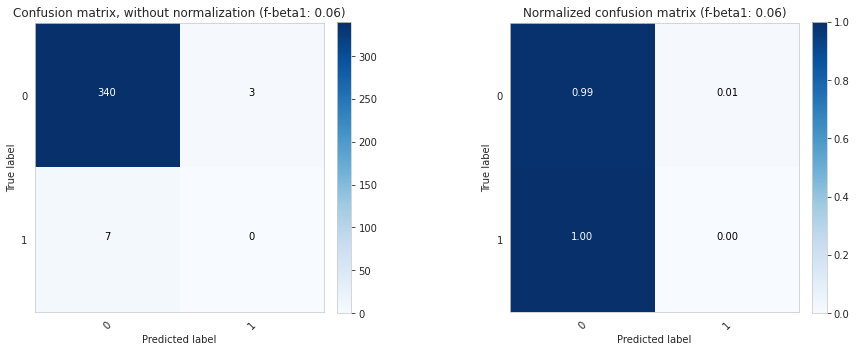

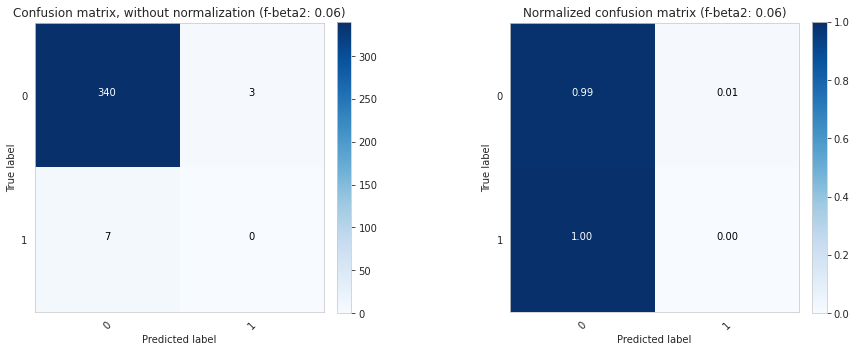



ROC Curve:


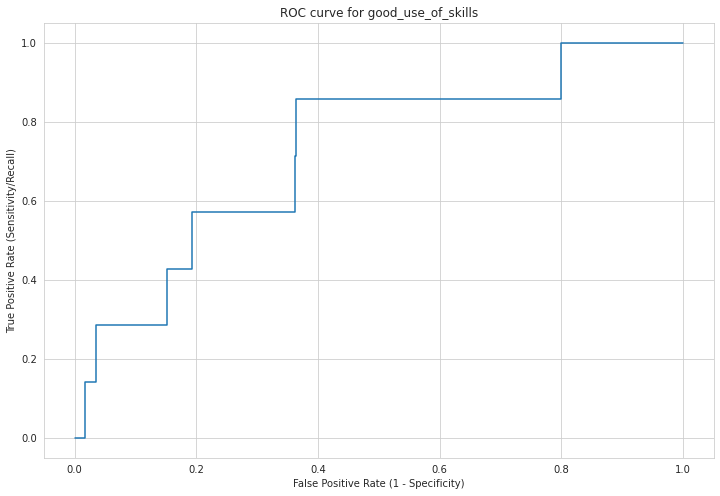

Predicted Probability Distribution:


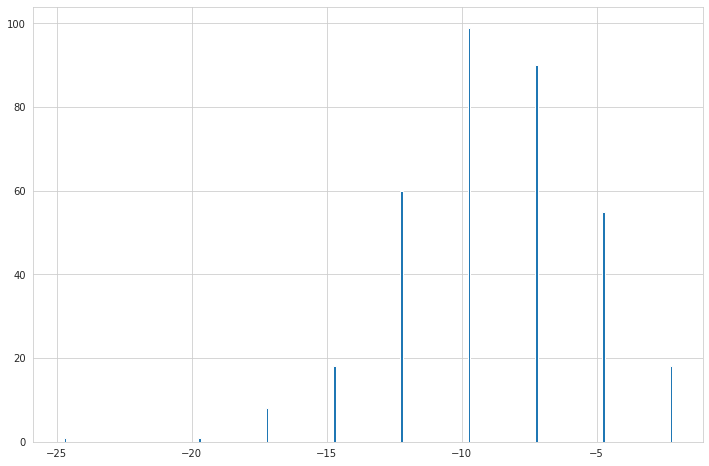



----------------------------------------------------------------------------------------------------


HAVE_NECESSARY_TOOLS

Null Accuracy:	0.9771428571428571
AUC Score:	0.9005847953216375

		f-beta05(0.47)		f-beta1(0.06)		f-beta2(0.06)
Accuracy:	0.9857142857142858	0.9885714285714285	0.9885714285714285	
Cohen's Kappa:	0.6085011185682327	0.7085761865112407	0.7085761865112407	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9884              0.9971              0.9927              342                 
1                   0.8                 0.5                 0.6154              8                   
avg/total           0.8942              0.7485              0.8041              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9913              0.9971              0.9942      

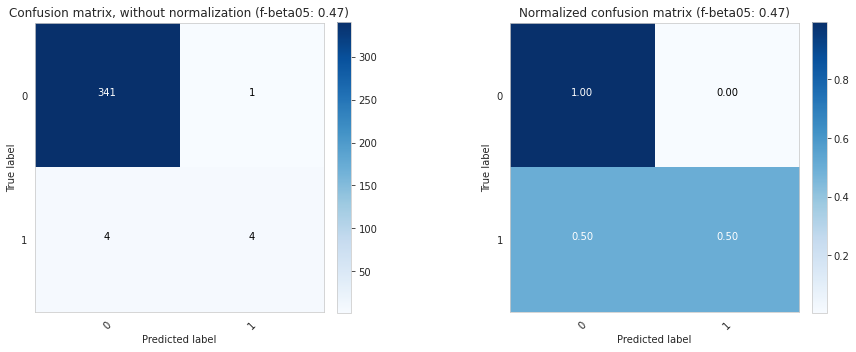

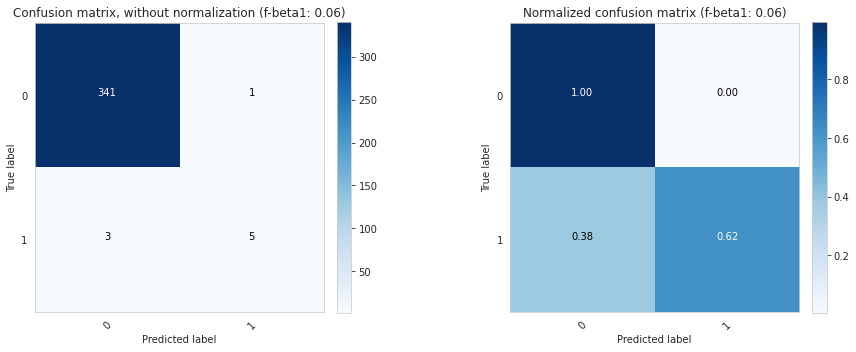

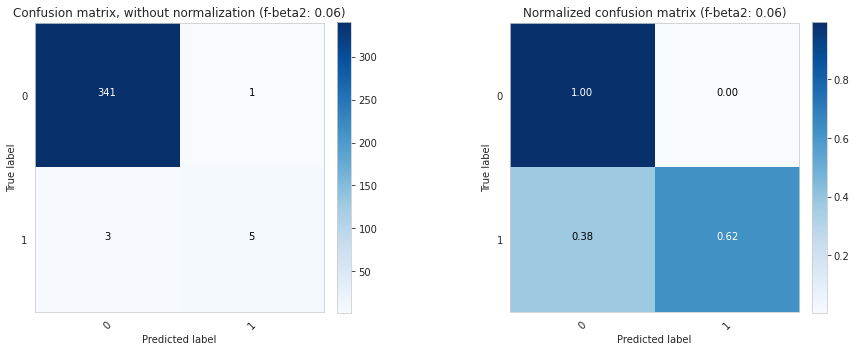



ROC Curve:


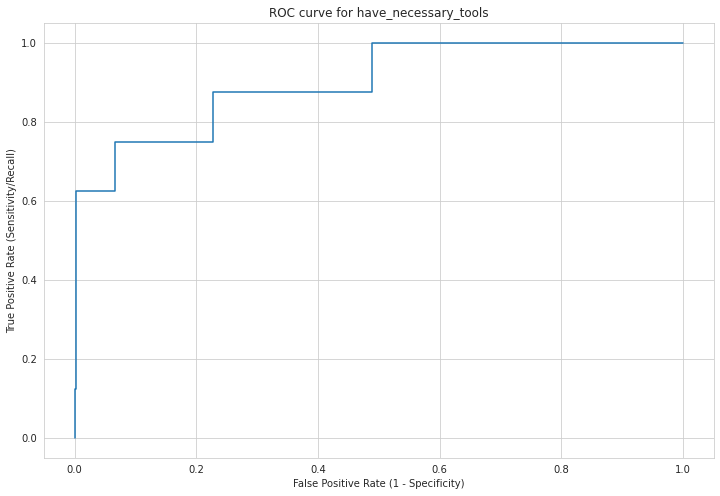

Predicted Probability Distribution:


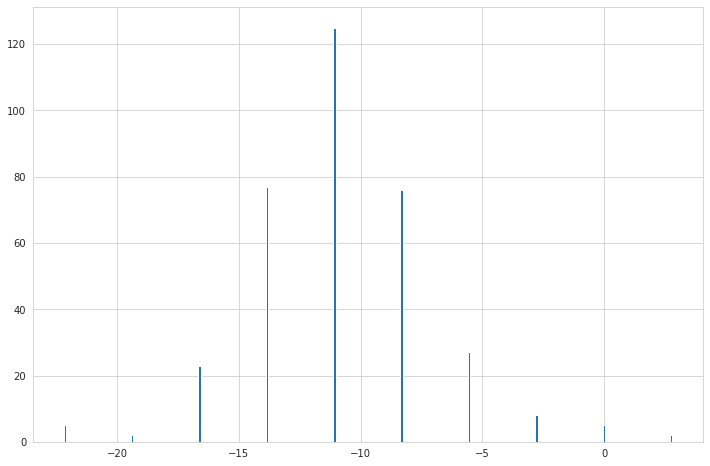



----------------------------------------------------------------------------------------------------


HAVE_VOICE_WITHIN_MY_INSTITUTION_VALUED_MEMBER_OF_MY_INSTITUTION

Null Accuracy:	0.9228571428571428
AUC Score:	0.7050796926957917

		f-beta05(0.47)		f-beta1(0.06)		f-beta2(0.06)
Accuracy:	0.9142857142857143	0.9057142857142857	0.9057142857142857	
Cohen's Kappa:	0.03934126258005488	0.022677271958030154	0.022677271958030154	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9246              0.9876              0.9551              323                 
1                   0.2                 0.037               0.0625              27                  
avg/total           0.5623              0.5123              0.5088              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9

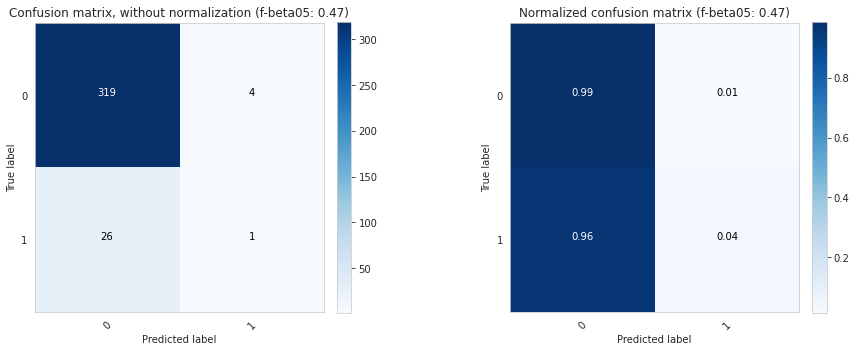

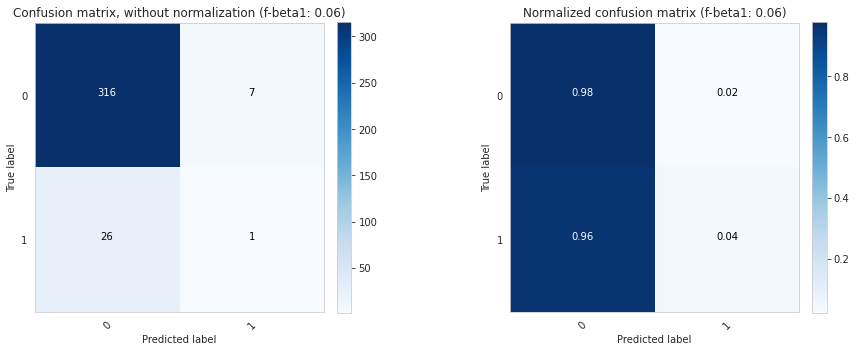

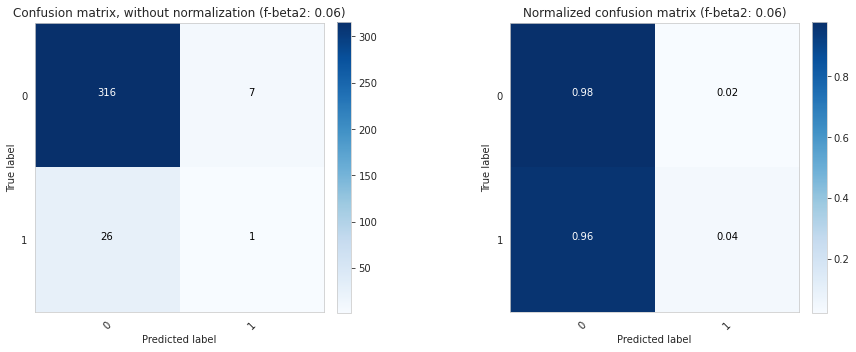



ROC Curve:


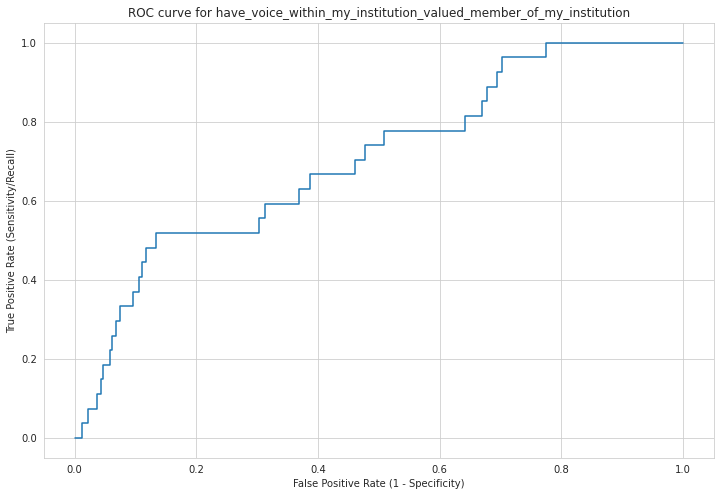

Predicted Probability Distribution:


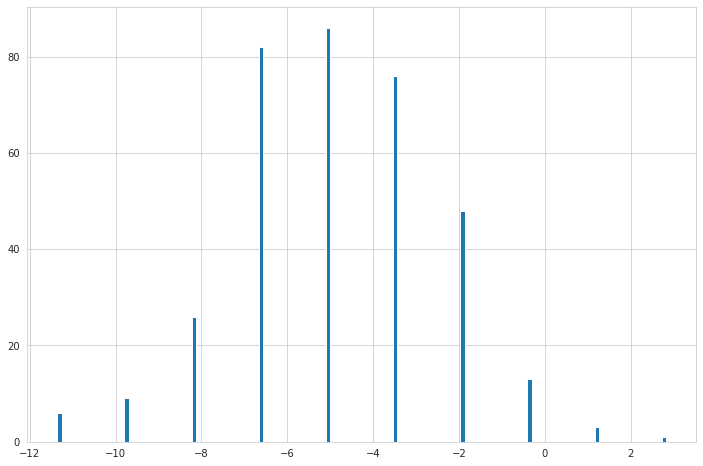



----------------------------------------------------------------------------------------------------


INTERNAL_PROCESSES_EFFECTIVE

Null Accuracy:	0.9571428571428572
AUC Score:	0.9170149253731343

		f-beta05(0.47)		f-beta1(0.06)		f-beta2(0.06)
Accuracy:	0.9428571428571428	0.9342857142857143	0.9342857142857143	
Cohen's Kappa:	0.2561105207226355	0.2688465031789282	0.2688465031789282	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9674              0.9731              0.9702              335                 
1                   0.3077              0.2667              0.2857              15                  
avg/total           0.6375              0.6199              0.628               350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9699              0.9612              0.96

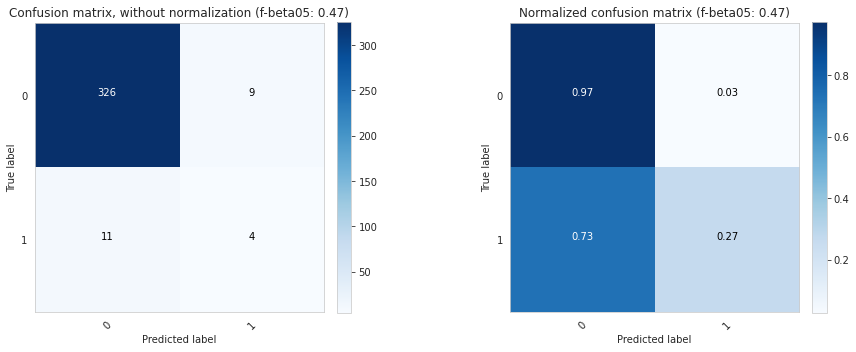

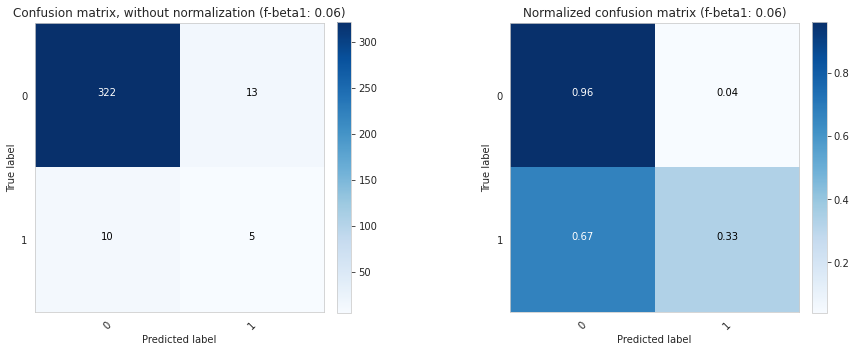

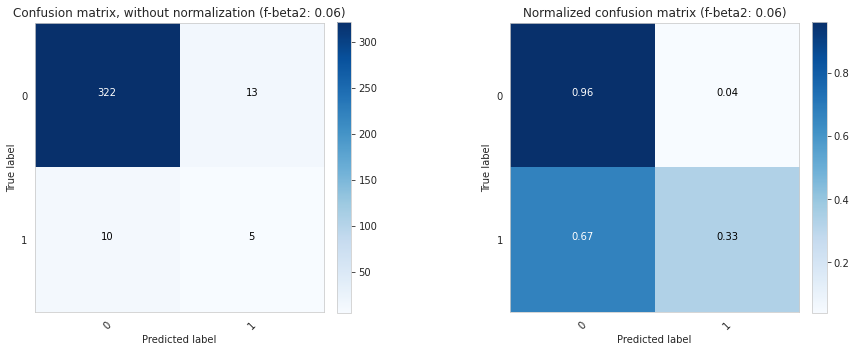



ROC Curve:


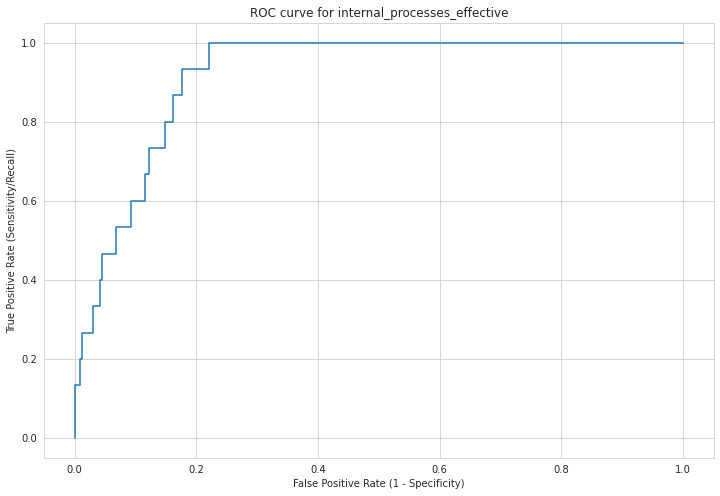

Predicted Probability Distribution:


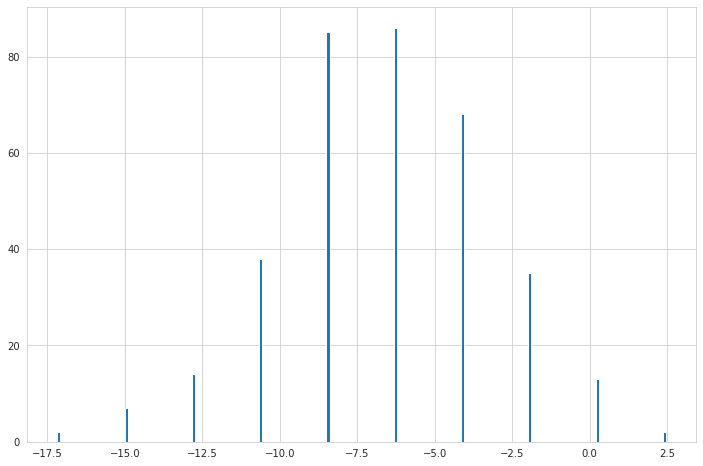



----------------------------------------------------------------------------------------------------


PARKING_TRANSPORTATION

Null Accuracy:	0.9771428571428571
AUC Score:	0.9901315789473684

		f-beta05(0.47)		f-beta1(0.06)		f-beta2(0.06)
Accuracy:	0.9771428571428571	0.9742857142857143	0.9742857142857143	
Cohen's Kappa:	0.5439739413680782	0.5134383688600557	0.5134383688600557	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9912              0.9854              0.9883              342                 
1                   0.5                 0.625               0.5556              8                   
avg/total           0.7456              0.8052              0.7719              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9912              0.9825              0.9868    

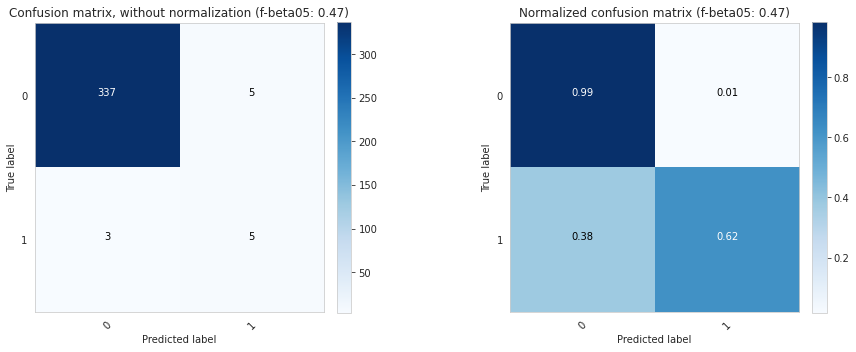

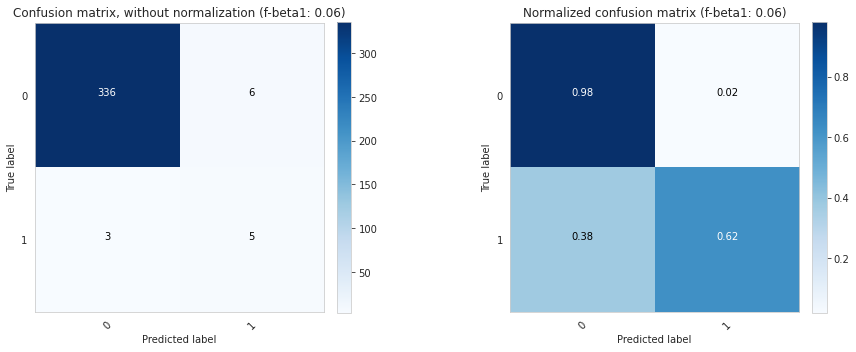

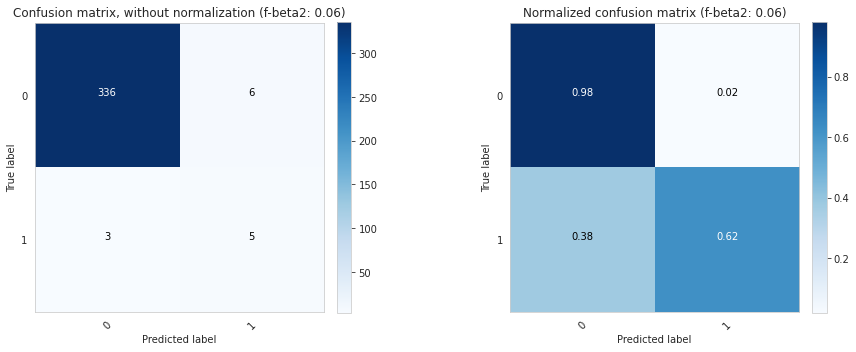



ROC Curve:


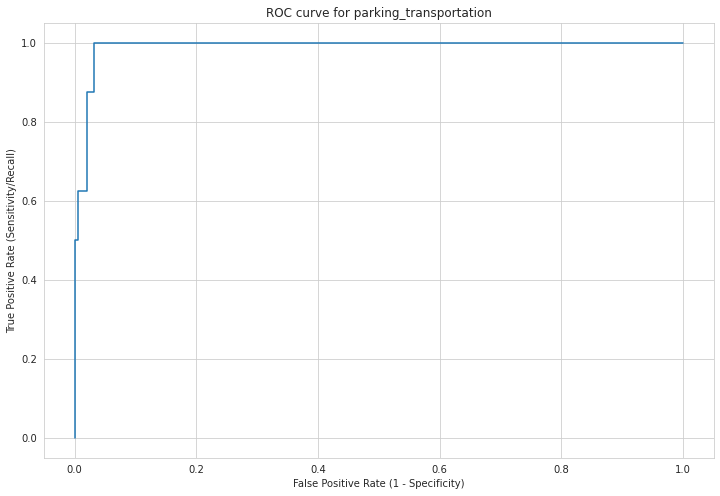

Predicted Probability Distribution:


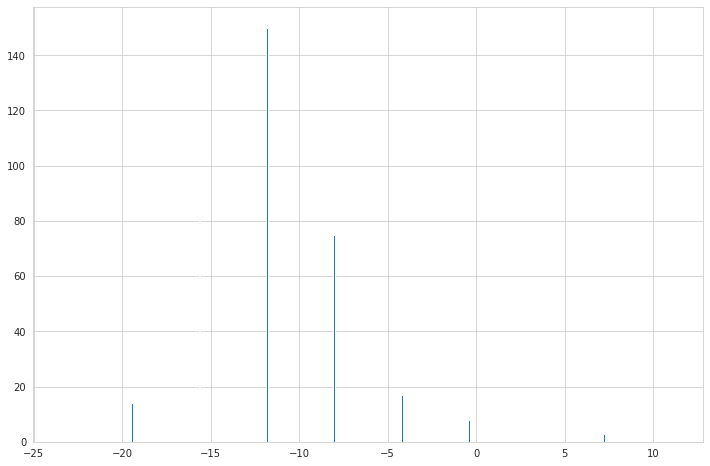



----------------------------------------------------------------------------------------------------


SALARY_PAY

Null Accuracy:	0.9142857142857143
AUC Score:	0.9047916666666667

		f-beta05(0.47)		f-beta1(0.06)		f-beta2(0.06)
Accuracy:	0.9114285714285715	0.8971428571428571	0.8971428571428571	
Cohen's Kappa:	0.3222985633978763	0.3015521064301553	0.3015521064301553	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9366              0.9688              0.9524              320                 
1                   0.4737              0.3                 0.3673              30                  
avg/total           0.7051              0.6344              0.6599              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9383              0.95                0.9441              32

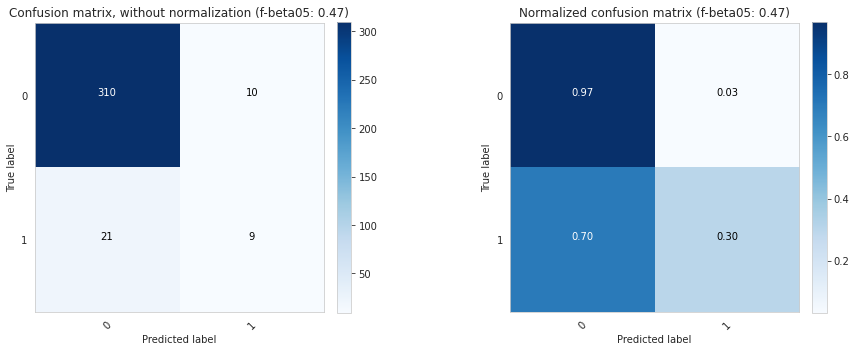

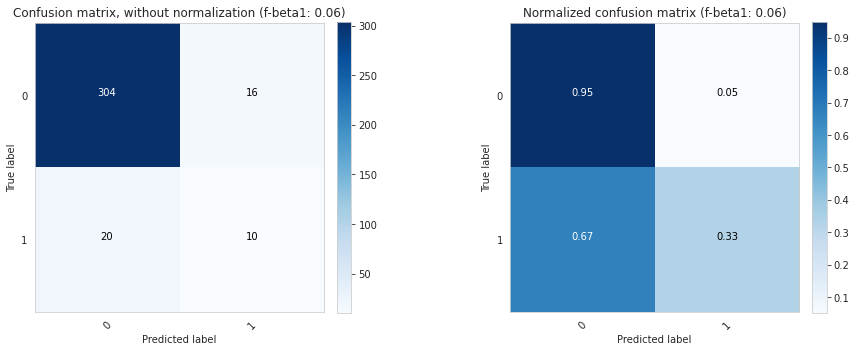

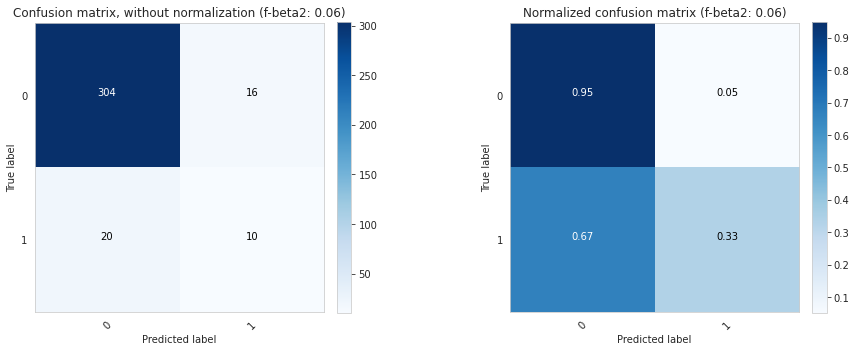



ROC Curve:


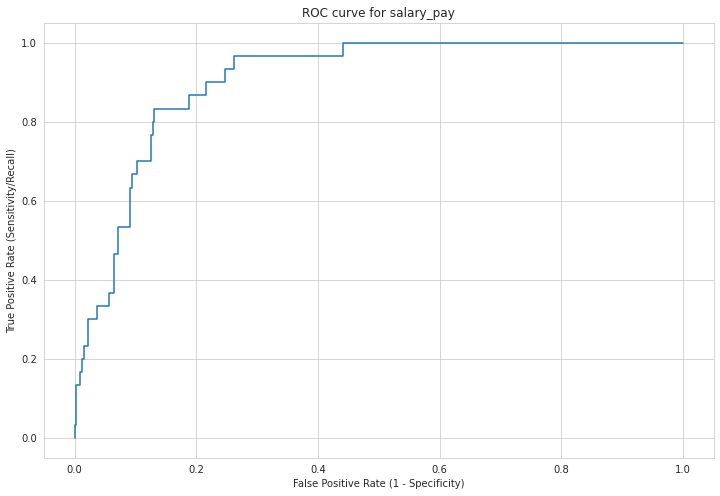

Predicted Probability Distribution:


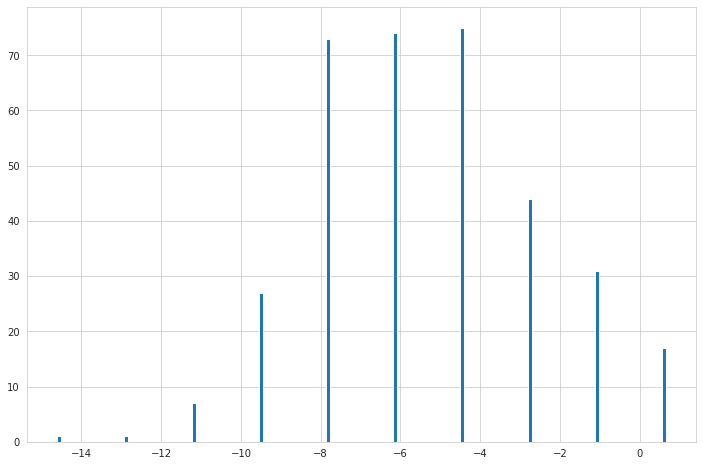



----------------------------------------------------------------------------------------------------


SATISFIED_WITH_DIVERSITY_PROGAMS

Null Accuracy:	0.9228571428571428
AUC Score:	0.7480793486985436

		f-beta05(0.47)		f-beta1(0.06)		f-beta2(0.06)
Accuracy:	0.8971428571428571	0.8828571428571429	0.8828571428571429	
Cohen's Kappa:	0.22499692459097065	0.19100236779794788	0.19100236779794788	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9388              0.9505              0.9446              323                 
1                   0.3043              0.2593              0.28                27                  
avg/total           0.6216              0.6049              0.6123              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9379              0.935            

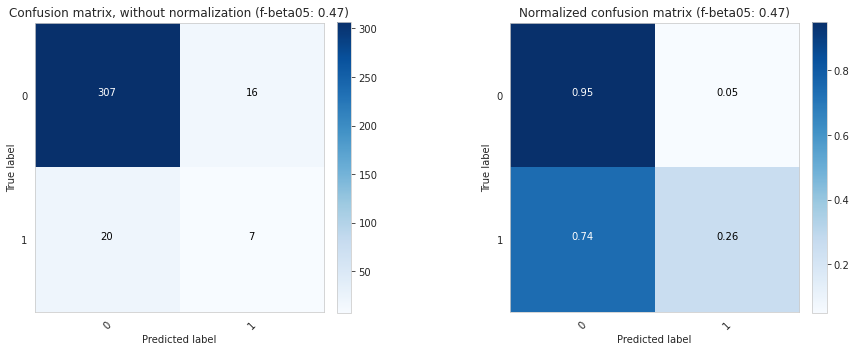

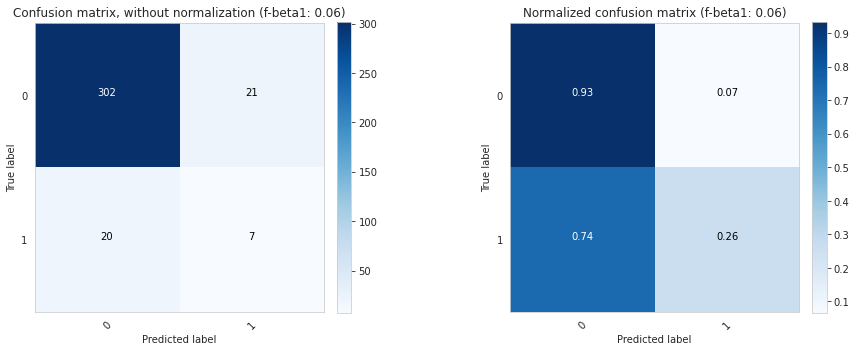

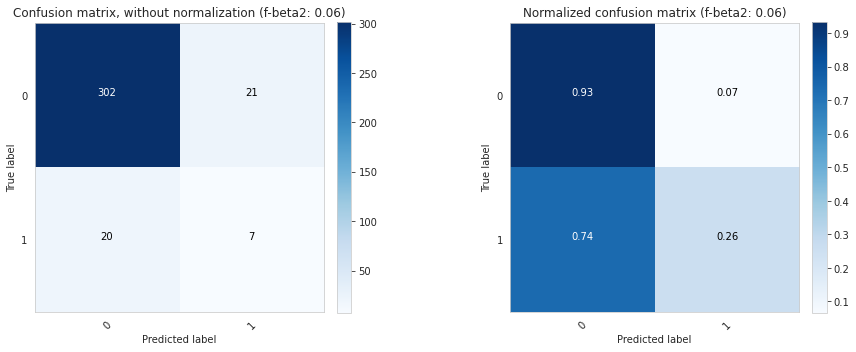



ROC Curve:


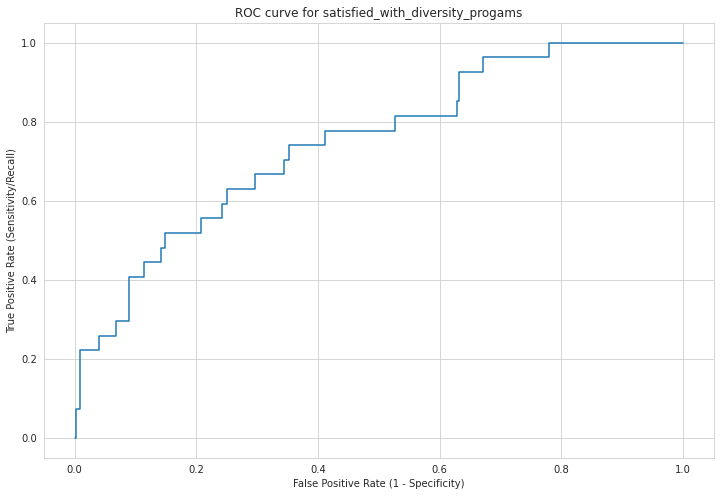

Predicted Probability Distribution:


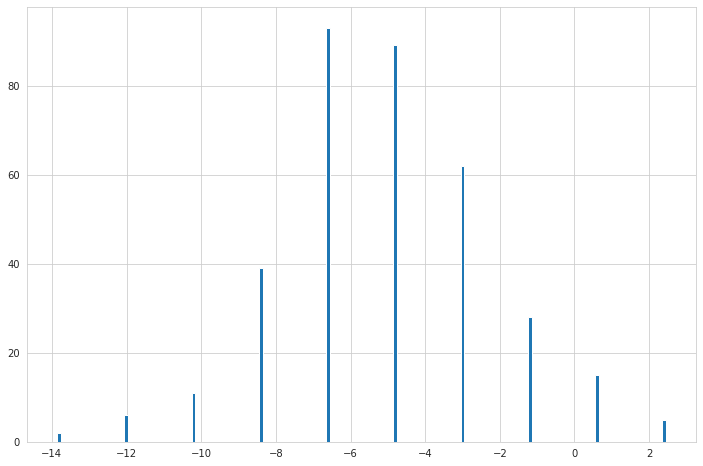



----------------------------------------------------------------------------------------------------


SUPERVISOR_EFFECTIVENESS_RESOLVES_STAFF_ISSUES

Null Accuracy:	0.8914285714285715
AUC Score:	0.8024628879892037

		f-beta05(0.47)		f-beta1(0.06)		f-beta2(0.06)
Accuracy:	0.8771428571428571	0.8742857142857143	0.8742857142857143	
Cohen's Kappa:	0.07747946548976348	0.07161803713527848	0.07161803713527848	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.8968              0.9744              0.9339              312                 
1                   0.2727              0.0789              0.1224              38                  
avg/total           0.5847              0.5267              0.5282              350                 

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.8964              0.9

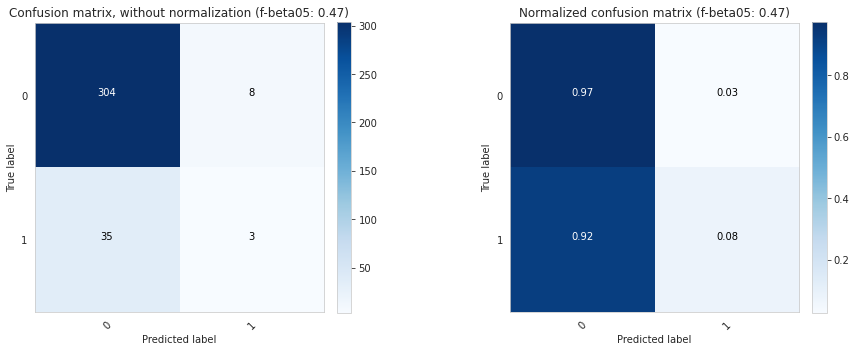

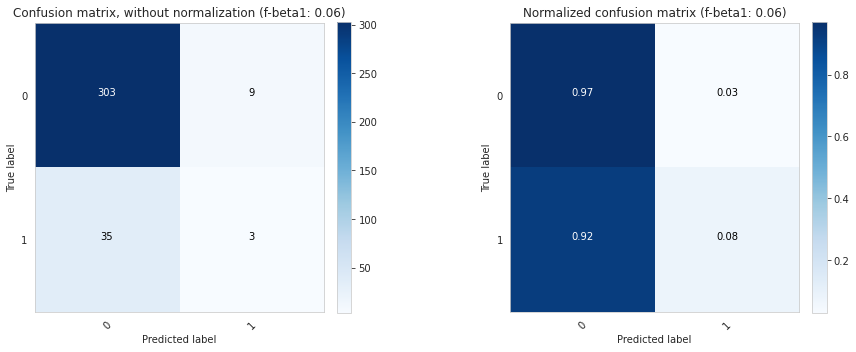

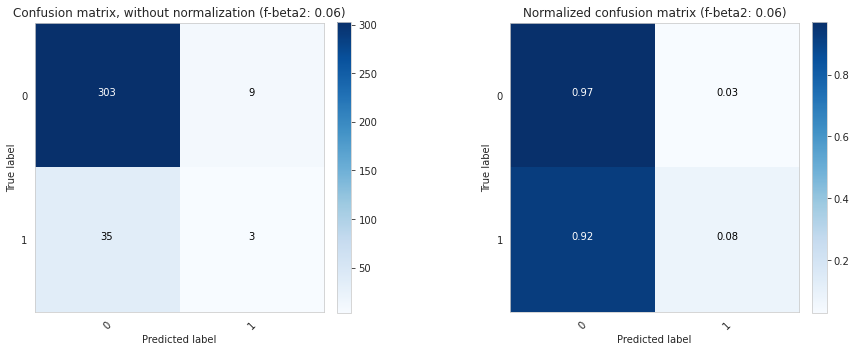



ROC Curve:


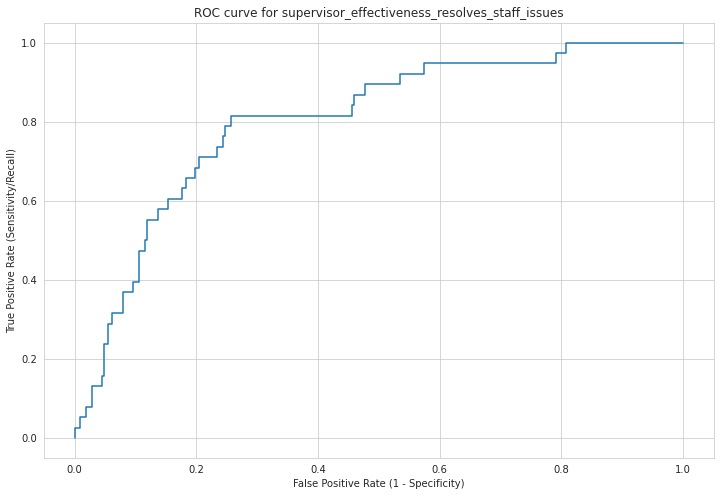

Predicted Probability Distribution:


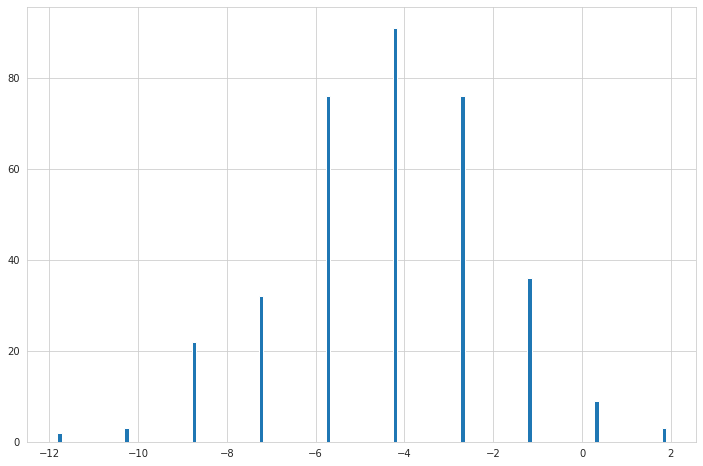



----------------------------------------------------------------------------------------------------




In [120]:
for lbl in label_metrics.keys():
    if (lbl == 'thresholds'): continue
    
    print(f'{lbl.upper()}\n')
    
    print(f'Null Accuracy:\t{label_metrics[lbl]["null_accuracy"]}')
    print(f'AUC Score:\t{label_metrics[lbl]["roc_auc"]}')
    print('')
    
    print(''.join([ f'\t\t{threshold}({np.round(v, 4)})' for threshold, v in label_metrics['thresholds'].items() ]))
    
    print('Accuracy:\t', end='')
    for threshold, v in label_metrics['thresholds'].items():
        print(f'{label_metrics[lbl]["accuracies"][threshold]}\t', end='')
    print('')
    
    print('Cohen\'s Kappa:\t', end='')
    for threshold, v in label_metrics['thresholds'].items():
        print(f'{label_metrics[lbl]["cohen_kappas"][threshold]}\t', end='')
    print('\n')
    
    print('Classification Reports:')
    for k in label_metrics[lbl]['report'].keys():
        print(f'{k}')
        print(f'{"":<20}' + ''.join([ f'{sub_key:<20}' for sub_key in label_metrics[lbl]['report'][k].keys() ]))
        
        for i in range(2):
            print(f'{i:<20}' + ''.join([ f'{np.round(v[i],4):<20}' 
                                      for v in label_metrics[lbl]['report'][k].values() ]))
        
        print(f'{"avg/total":<20}' + ''.join([ f'{ np.round(v.mean(),4) if (sub_key != "support") else np.round(v.sum(),4):<20}' 
                                     for sub_key, v in label_metrics[lbl]['report'][k].items() ]))
        print('')
    print('\n')
    
    print('Confusion Matrices:')
    for threshold, v in label_metrics['thresholds'].items():
        cm = label_metrics[lbl]['confusion_matrices'][threshold]
        
        # Plot non-normalized confusion matrix
        fig = plt.figure(figsize=(12,8))
        plt.subplot(1, 2, 1)
        plot_confusion_matrix(cm, classes=[0,1], 
                              title=f'Confusion matrix, without normalization ({threshold}: {np.round(v,4)})')

        # Plot normalized confusion matrix
        plt.subplot(1, 2, 2)
        plot_confusion_matrix(cm, classes=[0,1], normalize=True, 
                              title=f'Normalized confusion matrix ({threshold}: {np.round(v,4)})')

        fig.subplots_adjust(wspace=0.5)
        plt.show()
    print('\n')
    
    print('ROC Curve:')
    plt.figure(figsize=(12,8))
    plt.plot(label_metrics[lbl]['roc']['fpr'], label_metrics[lbl]['roc']['tpr'])
    plt.xlim = ([0.0, 1.0])
    plt.ylim = ([0.0, 1.0])
    plt.title(f'ROC curve for {lbl}')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity/Recall)')
    plt.grid(True)
    plt.show()
    
    print('Predicted Probability Distribution:')
    plt.figure(figsize=(12,8))
    plt.xlim = ([0.0, 1.0])
    plt.bar(label_metrics[lbl]['probability_distribution'][1][:-1], 
            label_metrics[lbl]['probability_distribution'][0], width=0.1)
    plt.show()
    
    print('\n')
    print('-'*100)
    print('\n')
        

## Ensemble forwards and backwards passes

In [ ]:
try:
    learn_fwd.purge(); learn = None;
    learn_bwd.purge(); learn_bwd = None;
    gc.collect()
    torch.cuda.empty_cache()
except: pass

bsz = 80
m_suf = '_multilabel'

dls = torch.load(STANDARD_THEME_SAW_PATH/f'data_cls_standard_themes_saw.pkl')

learn_fwd = load_learner(fname=STANDARD_THEME_SAW_PATH/f'fwd_export_clas{m_suf}.pkl')
learn_fwd.dls = dls
learn_bwd = load_learner(fname=STANDARD_THEME_SAW_PATH/f'bwd_export_clas{m_suf}.pkl')
learn_bwd.dls = dls

In [ ]:
probs_fwd, lbl_fwd, loss_fwd = learn_fwd.get_preds(with_loss=True, reorder=True)
probs_bwd, lbl_bwd, loss_bwd = learn_bwd.get_preds(with_loss=True, reorder=True)

probs_fwd.shape, probs_bwd.shape, loss_fwd.shape

In [ ]:
loss_fwd.mean(), loss_bwd.mean(), (loss_fwd.mean() + loss_bwd.mean()) / 2

In [ ]:
probs_final = (probs_fwd + probs_bwd) / 2

### Results

In [ ]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)

In [ ]:
# determine optimal threshold based on desired f-score
threshold_f05 = f05.opt_th(probs_fwd, lbl_fwd)
threshold_f1 = f1.opt_th(probs_fwd, lbl_fwd)
threshold_f2 = f2.opt_th(probs_fwd, lbl_fwd)

threshold_f05, threshold_f1, threshold_f2

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs_fwd, lbl_fwd, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs_fwd, lbl_fwd, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs_fwd, lbl_fwd, threshold_f2, sigmoid=False).item()

print('Fowards Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1}\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_multi(probs_fwd, lbl_fwd, sigmoid=False)}')

In [ ]:
# determine optimal threshold based on desired f-score
threshold_f05 = f05.opt_th(probs_bwd, lbl_fwd)
threshold_f1 = f1.opt_th(probs_bwd, lbl_fwd)
threshold_f2 = f2.opt_th(probs_bwd, lbl_fwd)

threshold_f05, threshold_f1, threshold_f2

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs_bwd, lbl_fwd, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs_bwd, lbl_fwd, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs_bwd, lbl_fwd, threshold_f2, sigmoid=False).item()

print('Backwards Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1}\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_multi(probs_bwd, lbl_fwd, sigmoid=False)}')

In [ ]:
# determine optimal threshold based on desired f-score
threshold_f05 = f05.opt_th(probs_final, lbl_fwd)
threshold_f1 = f1.opt_th(probs_final, lbl_fwd)
threshold_f2 = f2.opt_th(probs_final, lbl_fwd)

threshold_f05, threshold_f1, threshold_f2

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs_final, lbl_fwd, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs_final, lbl_fwd, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs_final, lbl_fwd, threshold_f2, sigmoid=False).item()

print('Ensemble Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1}\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_multi(probs_final, lbl_fwd, sigmoid=False)}')

In [ ]:
final_valid_loss = (loss_fwd.mean() + loss_bwd.mean()) / 2
final_valid_loss

In [ ]:
# save this information to be added to inference returned data
model_results = {
    'threshold_f05': threshold_f05,
    'threshold_f1': threshold_f1,
    'threshold_f2': threshold_f2,
    
    'val_acc_f05': val_acc_f05,
    'val_acc_f1': val_acc_f1,
    'val_acc_f2': val_acc_f2,
    'val_loss': final_valid_loss.item()
}

with open(STANDARD_THEME_SAW_PATH/'model_results.json', 'w') as f: json.dump(model_results, f)

### Inference (ad-hoc documents)

In [ ]:
print(STANDARD_THEME_SAW_LABELS)

In [ ]:
test_comments = [
    'The parking situation REALLY sucks around here.  It needs to be fixed',
    'I LOVE working at UCSD!!!  It is wonderful',
    """Some staff are just uninformed.There is no support for solo-individual study (no closed off rooms).
        Once a guy (quite tall) walked in into the girl's restroom and used the stalls standing up. 
        There was no line in the guy's restroom. This happened when I done and was going to walk out. 
        I was extremely uncomfortable""",
    "I love UCSD!!! It is a terrible place to work!",
    "I was really uncomfortable to express my opinion!!!"
]

for c in test_comments: print(learn_fwd.predict(c, with_input=True))

### Inference (batch ensemble)

In [ ]:
import datetime
yyyymmdd = datetime.date.today().strftime("%Y%m%d")

m_suf = '_multilabel'

# device = torch.device('cpu')
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(device)

In [ ]:
verbatims_df = pd.read_csv(LM_PATH/'all.csv', dtype={**TASK_LM_DTYPES}, parse_dates=[])

inf_df = verbatims_df[verbatims_df.SurveyID == 212].copy() #verbatims_df.copy() #verbatims_df[verbatims_df.SurveyID == 130].copy()
inf_df.reset_index(drop=True, inplace=True)
print(len(verbatims_df), len(inf_df))

corpus_cols = ['AnswerText']  # ['question_text', 'answer_text']

In [ ]:
def concat_pool(raw_outputs):
    last_rnn_layer = raw_outputs[:,-1,None] # (e.g. (bs,n_hid,emb_sz) => (bs,1,emb_sz)) 
    bsz = last_rnn_layer.shape[0] 
    
    avg_pool = F.adaptive_avg_pool1d(last_rnn_layer.permute(0,2,1), 1).view(bsz, -1)
    max_pool = F.adaptive_max_pool1d(last_rnn_layer.permute(0,2,1), 1).view(bsz, -1)
    last_outp = last_rnn_layer[:,-1,:]

    return torch.cat([last_outp, max_pool, avg_pool], 1)

In [ ]:
def get_theme_results(backwards:bool=False, m_suf:str='multilabel'):
    
    model_prefix = 'bwd' if backwards else 'fwd'
    
    # 1. grab learner, procs, and data
    inf_learn = load_learner(fname=STANDARD_THEME_SAW_PATH/f'{model_prefix}_export_clas_{m_suf}.pkl', cpu=False)
    inf_learn.model = inf_learn.model.to(device)
    inf_learn.model = inf_learn.model.eval()
    
    # 2. define a suitable dataloader
    tok_inf_df, tok_counts = tokenize_df(inf_df, corpus_cols)
    inf_dl = inf_learn.dls.test_dl(tok_inf_df, rm_type_tfms=None, bs=128)
    if (backwards): inf_dl.tfms.add(Transform(lambda nums: nums.flip(0)))

    # 3. get probs and document vectors
    test_probs, doc_vecs, concat_doc_vecs = [], [], []
    with torch.no_grad():
        for index, b in enumerate(inf_dl):
            if index % 1000 == 0:  print(index)

            # reset hidden state (if you don't do this you will OOM)
            inf_learn.model.reset()
            
            # note: even though there is no targets, each batch is a tuple!
            probs, raw_outputs, outputs = inf_learn.model(b[0])
            
            # why "detach"? the computation of gradients wrt the weights of netG can be fully 
            # avoided in the backward pass if the graph is detached where it is.
            test_probs.append(to_detach(probs))
            doc_vecs.append(to_detach(raw_outputs[:,-1,:]))
            concat_doc_vecs.append(to_detach(concat_pool(raw_outputs)))

    all_probs = L(torch.cat(test_probs))
    all_vecs = L(torch.cat(doc_vecs))
    all_concat_vecs = L(torch.cat(concat_doc_vecs))

    # 4. ensure results are returned in order
    # test_dl.get_idxs() => unsorted/original order items
    all_probs = all_probs[0][np.argsort(inf_dl.get_idxs())]
    all_vecs = all_vecs[0][np.argsort(inf_dl.get_idxs())]
    all_concat_vecs = all_concat_vecs[0][np.argsort(inf_dl.get_idxs())]
        
    # 5. return ordered results
    inf_learn, inf_data = None, None; gc.collect()
    
    return all_probs, all_vecs, all_concat_vecs

In [ ]:
%time

probs_fwd, vecs_fwd, concat_vecs_fwd = get_theme_results(backwards=False)
probs_bwd, vecs_bwd, concat_vecs_bwd = get_theme_results(backwards=True)

probs_final = torch.sigmoid((probs_fwd + probs_bwd) / 2)

print(probs_final.shape)
print(probs_fwd.shape, vecs_fwd.shape, concat_vecs_fwd.shape)
print(probs_bwd.shape, vecs_bwd.shape, concat_vecs_bwd.shape)

Add the probabilities of each label to `inf_df`

In [ ]:
prob_labels = ['prob_' + lbl for lbl in STANDARD_THEME_SAW_LABELS]
probs_df = pd.DataFrame(probs_final.numpy(), columns=prob_labels)
probs_df.head()

In [ ]:
# test_df_filtered.update(probs_df)
final_df = pd.concat([inf_df, probs_df], axis=1)

Add in predictions based on f1 threshold

In [ ]:
for lbl in STANDARD_THEME_SAW_LABELS:
    final_df[f'pred_{lbl}'] = (final_df[f'prob_{lbl}'] > threshold_f1).astype(np.int64)

Include found thresholds

In [ ]:
final_df['threshold_f05'] = threshold_f05
final_df['threshold_f1'] = threshold_f1
final_df['threshold_f2'] = threshold_f2

final_df['val_acc_f05'] = val_acc_f05
final_df['val_acc_f1'] = val_acc_f1
final_df['val_acc_f2'] = val_acc_f2

final_df['val_loss'] = final_valid_loss

In [ ]:
final_df.head()

In [ ]:
final_df.AnswerText[final_df.Id == 589546].values

In [ ]:
import datetime
final_df.to_csv(STANDARD_THEME_SAW_PATH/f'{yyyymmdd}_ensemble_predictions{m_suf}.csv', index=False)

### Save document vectors

In [ ]:
%time 

np.save(str(STANDARD_THEME_SAW_PATH/f'{yyyymmdd}_fwd_concat_docvecs_d400{m_suf}.npy'), concat_vecs_fwd.numpy())  
np.save(str(STANDARD_THEME_SAW_PATH/f'{yyyymmdd}_fwd_docvecs_d400{m_suf}.npy'), vecs_fwd.numpy())

np.save(str(STANDARD_THEME_SAW_PATH/f'{yyyymmdd}_bwd_concat_docvecs_d400{m_suf}.npy'), concat_vecs_bwd.numpy())  
np.save(str(STANDARD_THEME_SAW_PATH/f'{yyyymmdd}_bwd_docvecs_d400{m_suf}.npy'), vecs_bwd.numpy())

### Playground

In [ ]:
final_df.iloc[0].threshold_f05, final_df.iloc[0].threshold_f1, final_df.iloc[0].threshold_f2